<a href="https://colab.research.google.com/github/gbadeleye/Manufacturing-Projects/blob/main/Multistage_Continuous_Flow_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AUTHOR:** Gbenga Adeleye (insert LinkedIn link)

**DATE:** 7 September 2022

# INTRODUCTION

This is a project, which will attempt to apply Machine Learning (ML) techniques to a dataset made available by [Liveline Technologies](https://www.liveline.tech/) on the [Kaggle site](https://www.kaggle.com/datasets/supergus/multistage-continuousflow-manufacturing-process?rvi=1). As indicated in the Kaggle page, the dataset has been taken from an actual manufacturing line near Detroit, Michigan, USA. The line is a high-speed, continuous manufacturing process with parallel and series stages.

**MANUFACTURING PROCESS DESCRIPTION**

The dataset comes from a multi-stage continuous flow manufacturing process. The production line is a high-speed, continuous manufacturing process with parallel and series stages. The line consists of 2 stages. In the first stage, there are 3 machines - Machines 1, 2, and 3, which operate in parallel, and feed their outputs into a step that combines the flows. Output from the combiner is measured in 15 locations surrounding the outer surface of the material exiting the combiner. The combiner output then flows into a second stage, where 2 machines - Machines 4 and 5 - process in series. After Machine 5, measurements are made again in the same 15 locations surrounding the outer surface of the material exiting Machine 5.


**DATA FILE DESCRIPTION**

The dataset is a time series that comes from a production line test run spanning approx. 4 hours. Samples are in 1-sec intervals. In the first stage, Machines 1, 2, and 3 operate in parallel, and feed their outputs into a step that combines the flows. Output from the combiner is measured in 15 locations. Next, the output flows into a second stage, where Machines 4 and 5 process in series. Measurements are made again in the same 15 locations.

The dataset is in a .csv file and is included with this notebook. The 30 measurements are noisy, and each measurement also has a target or Setpoint (SP) variable. There are 116 columns in the dataset (1 timestamp column + 115 variables columns). More details about the dataset can be found in the included .txt file (notes_on_dataset.txt).

The dataset source Kaggle page does not provide an illustrative process flow diagram for the production line. However, a diagram has been sketched by the author of this project, based on the process description above, to aid comprehension of the manufacturing process. See below:


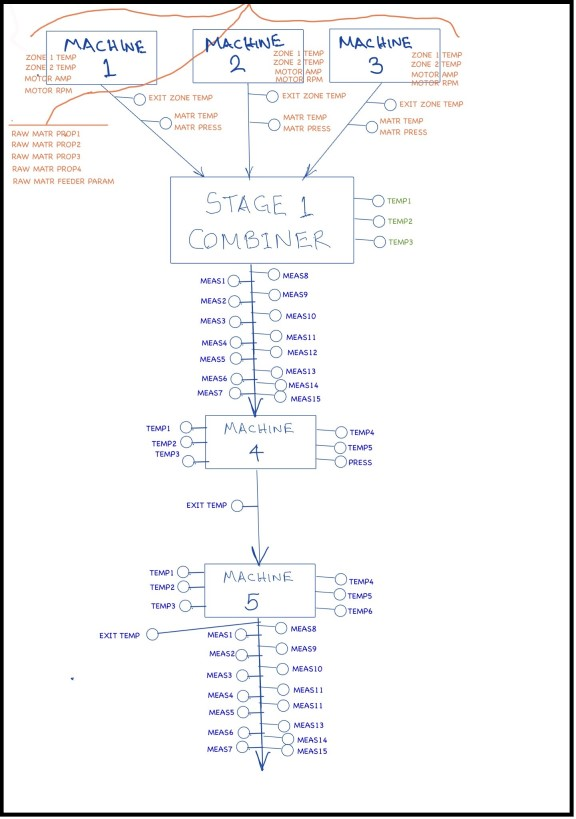

**OBJECTIVE**

The objective of this project is to apply ML techniques to the Liveline dataset to train model(s) to predict the 15 measurements of the Stage 1 Combiner output. The Stage 2 measurements models will not be part of this project's scope.

This objective serves as an enabler for several production applications, such as developing process control applications, which could help optimize output of the value-driving process variables of the production line, or help operate the production line within health, environmental, and equipment safety limits. The models can also be used for anomaly detection, which could aid early fault diagnosis in event of operational issues in the production line.

The objective is implemented in this notebook (a Python environment), which consists of the following sections:


*   Requisite Library Installation & Dataset Load/Preview
*   Dataframe Review & Pre-processing
*   Dataframe EDA
*   Targets & Features Selection
*   Model Structure
*   Baseline Model Identification & Evaluation
*   Model Parameters Tuning
*   Conclusion & Suggested Opportunities








# REQUISITE LIBRARY INSTALLATION & DATASET LOAD/PREVIEW

In [ ]:
 # Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm
!pip install gekko
from gekko import GEKKO
path = '/content/drive/MyDrive/Kaggle/General Forked Projects & Notebooks/Multi-stage continuous-flow manufacturing process.zip (Unzipped Files)/'

In [ ]:
# Load Dataset, parse "time-stamp" column as 1-sec time variable and set as index
df = pd.read_csv('/content/drive/MyDrive/Kaggle/General Forked Projects & Notebooks/Multi-stage continuous-flow manufacturing process.zip (Unzipped Files)/continuous_factory_process.csv',
                 parse_dates=['time_stamp']).set_index('time_stamp').to_period('1S')
df.index=df.index.to_timestamp()
df.head()

# DATAFRAME REVIEW & PRE-PROCESSING

**CHECK SEQUENTIALITY OF DATAFRAME INDEX TIMESTAMPS**

Before continuing, there is the need to check the timestamps in the dataframe index, to confirm that they're sequential, i.e. there are no missing timestamps and/or instances of multiple entries of existing timestamps.

In [ ]:
# Function to check sequentiality of dataframe timestamps
def check_df_index():
  # First create list of sequential timestamps, whose start/end timestamps coincide with those of the dataframe index and follow the same
  # 1-sec frequency
  range1=pd.date_range(start=df.index[0],end=df.index[-1],freq=pd.DateOffset(seconds=1))
  
  # Copy timestamps of dataframe index
  range2=df.index
  
  # Perform Analyses
  print(f"The following timestamps are not in the dataframe index:\n{[str(x) for x in range1.difference(range2).to_list()]}")
  print(f"\nThe lengths of the dataframe index and the reconstructed sequential index are:\ndf index: {len(range2)}\nsequential index: {len(range1)}")
  counts={}
  names=[str(x) for x in range2.to_list()]
  for name in names:
    counts[name]=counts.get(name,0)+1
  print(f"\nThe timestamps appearing multiple times in the dataframe index including their counts are:\n{[(x,counts[x]) for x in counts.keys() if counts[x]>1]}")

check_df_index()

So, what appears to be happening here is that the dataframe index is missing about 14 timestamps, e.g. '2019-03-06 11:26:16'. To make up the completeness of the index length, some of the existing timestamps have repeated entries. For example, '2019-03-06 10:53:06' has up to 3 entries.

Not sure if this points to potential issues with the production plant's data logging tool during the test run, but having the timestamp anomalies in the dataframe index might impact the quality of its subsequent EDA, and could lead to errors in the model training steps.

Next, there is the need to check samples of the repeated timestamps, to see if the corresponding dataframe column entries are also repeated, or if unique.

In [ ]:
display(df.loc['2019-03-06 10:52:52'])
display(df.loc['2019-03-06 10:53:06'])

The 2 repeated timestamps sampled appear to have unique entries in their columns, e.g. 'Machine1.RawMaterialFeederParameter.U.Actual', 'Machine1.Zone2Temperature.C.Actual', 'Machine1.MotorAmperage.U.Actual',etc. The column entries are therefore non-repeated, and therefore should be preserved.

To resolve these timestamp anomalies, the proposal here is to rebuild the dataframe index, to make the timestamps sequential.

In [ ]:
# Rebuild dataframe index and re-run dataframe index check
df.index = [pd.Timestamp(x) for x in pd.date_range(start=df.index[0],end=df.index[-1],freq=pd.DateOffset(seconds=1))]
check_df_index()

Dataframe index timestamps have now been fixed. 

Next, will continue dataframe review/pre-processing.

---------------------------------------------------------------------------

**RENAME COLUMNS**

In [ ]:
# List columns in dataset
display(df.columns)

Columns have lengthy names. Proposal here is to rename to simpler representations before commencing EDA. Column renaming steps will leverage process control terminologies (e.g. SP, PV, etc) to help simplify renames.

In [ ]:
# Rename columns. See dictionary below for proposed names

# Create dictionary for new column names
col_newnames={'AmbientConditions.AmbientHumidity.U.Actual':'Ambient_Humidity',
              'AmbientConditions.AmbientTemperature.U.Actual':'Ambient_Temperature',
              'Machine1.RawMaterial.Property1':'M1_RawMat_Prop1',
              'Machine1.RawMaterial.Property2':'M1_RawMat_Prop2',
              'Machine1.RawMaterial.Property3':'M1_RawMat_Prop3',
              'Machine1.RawMaterial.Property4':'M1_RawMat_Prop4',
              'Machine1.RawMaterialFeederParameter.U.Actual':'M1_RawMat_FdrParam',
              'Machine1.Zone1Temperature.C.Actual':'M1_Zone1_Temp_PV',
              'Machine1.Zone2Temperature.C.Actual':'M1_Zone2_Temp_PV',
              'Machine1.MotorAmperage.U.Actual':'M1_Motor_Amp_PV',
              'Machine1.MotorRPM.C.Actual':'M1_Motor_RPM_PV',
              'Machine1.MaterialPressure.U.Actual':'M1_Matr_Press_PV',
              'Machine1.MaterialTemperature.U.Actual':'M1_Matr_Temp_PV',
              'Machine1.ExitZoneTemperature.C.Actual':'M1_Exit_Temp_PV',
              'Machine2.RawMaterial.Property1':'M2_RawMat_Prop1',
              'Machine2.RawMaterial.Property2':'M2_RawMat_Prop2',
              'Machine2.RawMaterial.Property3':'M2_RawMat_Prop3',
              'Machine2.RawMaterial.Property4':'M2_RawMat_Prop4',
              'Machine2.RawMaterialFeederParameter.U.Actual':'M2_RawMat_FdrParam',
              'Machine2.Zone1Temperature.C.Actual':'M2_Zone1_Temp_PV',
              'Machine2.Zone2Temperature.C.Actual':'M2_Zone2_Temp_PV',
              'Machine2.MotorAmperage.U.Actual':'M2_Motor_Amp_PV',
              'Machine2.MotorRPM.C.Actual':'M2_Motor_RPM_PV',
              'Machine2.MaterialPressure.U.Actual':'M2_Matr_Press_PV',
              'Machine2.MaterialTemperature.U.Actual':'M2_Matr_Temp_PV',
              'Machine2.ExitZoneTemperature.C.Actual':'M2_Exit_Temp_PV',
              'Machine3.RawMaterial.Property1':'M3_RawMat_Prop1',
              'Machine3.RawMaterial.Property2':'M3_RawMat_Prop2',
              'Machine3.RawMaterial.Property3':'M3_RawMat_Prop3',
              'Machine3.RawMaterial.Property4':'M3_RawMat_Prop4',
              'Machine3.RawMaterialFeederParameter.U.Actual':'M3_RawMat_FdrParam',
              'Machine3.Zone1Temperature.C.Actual':'M3_Zone1_Temp_PV',
              'Machine3.Zone2Temperature.C.Actual':'M3_Zone2_Temp_PV',
              'Machine3.MotorAmperage.U.Actual':'M3_Motor_Amp_PV',
              'Machine3.MotorRPM.C.Actual':'M3_Motor_RPM_PV',
              'Machine3.MaterialPressure.U.Actual':'M3_Matr_Press_PV',
              'Machine3.MaterialTemperature.U.Actual':'M3_Matr_Temp_PV',
              'Machine3.ExitZoneTemperature.C.Actual':'M3_Exit_Temp_PV',
              'FirstStage.CombinerOperation.Temperature1.U.Actual':'S1_CombnOp_Temp1_PV',
              'FirstStage.CombinerOperation.Temperature2.U.Actual':'S1_CombnOp_Temp2_PV',
              'FirstStage.CombinerOperation.Temperature3.C.Actual':'S1_CombnOp_Temp3_PV',
              'Stage1.Output.Measurement0.U.Actual':'S1_Out_Meas0_PV',
              'Stage1.Output.Measurement0.U.Setpoint':'S1_Out_Meas0_SP',   
              'Stage1.Output.Measurement1.U.Actual':'S1_Out_Meas1_PV',
              'Stage1.Output.Measurement1.U.Setpoint':'S1_Out_Meas1_SP',  
              'Stage1.Output.Measurement2.U.Actual':'S1_Out_Meas2_PV',
              'Stage1.Output.Measurement2.U.Setpoint':'S1_Out_Meas2_SP', 
              'Stage1.Output.Measurement3.U.Actual':'S1_Out_Meas3_PV',
              'Stage1.Output.Measurement3.U.Setpoint':'S1_Out_Meas3_SP',  
              'Stage1.Output.Measurement4.U.Actual':'S1_Out_Meas4_PV',
              'Stage1.Output.Measurement4.U.Setpoint':'S1_Out_Meas4_SP',
              'Stage1.Output.Measurement5.U.Actual':'S1_Out_Meas5_PV',
              'Stage1.Output.Measurement5.U.Setpoint':'S1_Out_Meas5_SP',
              'Stage1.Output.Measurement6.U.Actual':'S1_Out_Meas6_PV',
              'Stage1.Output.Measurement6.U.Setpoint':'S1_Out_Meas6_SP',
              'Stage1.Output.Measurement7.U.Actual':'S1_Out_Meas7_PV',
              'Stage1.Output.Measurement7.U.Setpoint':'S1_Out_Meas7_SP',
              'Stage1.Output.Measurement8.U.Actual':'S1_Out_Meas8_PV',
              'Stage1.Output.Measurement8.U.Setpoint':'S1_Out_Meas8_SP', 
              'Stage1.Output.Measurement9.U.Actual':'S1_Out_Meas9_PV',
              'Stage1.Output.Measurement9.U.Setpoint':'S1_Out_Meas9_SP',
              'Stage1.Output.Measurement10.U.Actual':'S1_Out_Meas10_PV',
              'Stage1.Output.Measurement10.U.Setpoint':'S1_Out_Meas10_SP',  
              'Stage1.Output.Measurement11.U.Actual':'S1_Out_Meas11_PV',
              'Stage1.Output.Measurement11.U.Setpoint':'S1_Out_Meas11_SP',   
              'Stage1.Output.Measurement12.U.Actual':'S1_Out_Meas12_PV',
              'Stage1.Output.Measurement12.U.Setpoint':'S1_Out_Meas12_SP',  
              'Stage1.Output.Measurement13.U.Actual':'S1_Out_Meas13_PV',
              'Stage1.Output.Measurement13.U.Setpoint':'S1_Out_Meas13_SP',
              'Stage1.Output.Measurement14.U.Actual':'S1_Out_Meas14_PV',
              'Stage1.Output.Measurement14.U.Setpoint':'S1_Out_Meas14_SP',
              'Machine4.Temperature1.C.Actual':'M4_Temp1_PV',
              'Machine4.Temperature2.C.Actual':'M4_Temp2_PV',
              'Machine4.Temperature3.C.Actual':'M4_Temp3_PV',
              'Machine4.Temperature4.C.Actual':'M4_Temp4_PV', 
              'Machine4.Temperature5.C.Actual':'M4_Temp5_PV',
              'Machine4.ExitTemperature.U.Actual':'M4_Exit_Temp_PV',
              'Machine4.Pressure.C.Actual':'M4_Press_PV',
              'Machine5.Temperature1.C.Actual':'M5_Temp1_PV',
              'Machine5.Temperature2.C.Actual':'M5_Temp2_PV', 
              'Machine5.Temperature3.C.Actual':'M5_Temp3_PV',
              'Machine5.Temperature4.C.Actual':'M5_Temp4_PV', 
              'Machine5.Temperature5.C.Actual':'M5_Temp5_PV',
              'Machine5.Temperature6.C.Actual':'M5_Temp6_PV', 
              'Machine5.ExitTemperature.U.Actual':'M5_Exit_Temp_PV',
              'Stage2.Output.Measurement0.U.Actual':'S2_Out_Meas0_PV',
              'Stage2.Output.Measurement0.U.Setpoint':'S2_Out_Meas0_SP',
              'Stage2.Output.Measurement1.U.Actual':'S2_Out_Meas1_PV',
              'Stage2.Output.Measurement1.U.Setpoint':'S2_Out_Meas1_SP',
              'Stage2.Output.Measurement2.U.Actual':'S2_Out_Meas2_PV',
              'Stage2.Output.Measurement2.U.Setpoint':'S2_Out_Meas2_SP',
              'Stage2.Output.Measurement3.U.Actual':'S2_Out_Meas3_PV',
              'Stage2.Output.Measurement3.U.Setpoint':'S2_Out_Meas3_SP',
              'Stage2.Output.Measurement4.U.Actual':'S2_Out_Meas4_PV',
              'Stage2.Output.Measurement4.U.Setpoint':'S2_Out_Meas4_SP',
              'Stage2.Output.Measurement5.U.Actual':'S2_Out_Meas5_PV',
              'Stage2.Output.Measurement5.U.Setpoint':'S2_Out_Meas5_SP',
              'Stage2.Output.Measurement6.U.Actual':'S2_Out_Meas6_PV',
              'Stage2.Output.Measurement6.U.Setpoint':'S2_Out_Meas6_SP',
              'Stage2.Output.Measurement7.U.Actual':'S2_Out_Meas7_PV',
              'Stage2.Output.Measurement7.U.Setpoint':'S2_Out_Meas7_SP',
              'Stage2.Output.Measurement8.U.Actual':'S2_Out_Meas8_PV',
              'Stage2.Output.Measurement8.U.Setpoint':'S2_Out_Meas8_SP',
              'Stage2.Output.Measurement9.U.Actual':'S2_Out_Meas9_PV',
              'Stage2.Output.Measurement9.U.Setpoint':'S2_Out_Meas9_SP',
              'Stage2.Output.Measurement10.U.Actual':'S2_Out_Meas10_PV',
              'Stage2.Output.Measurement10.U.Setpoint':'S2_Out_Meas10_SP',
              'Stage2.Output.Measurement11.U.Actual':'S2_Out_Meas11_PV',
              'Stage2.Output.Measurement11.U.Setpoint':'S2_Out_Meas11_SP',
              'Stage2.Output.Measurement12.U.Actual':'S2_Out_Meas12_PV',
              'Stage2.Output.Measurement12.U.Setpoint':'S2_Out_Meas12_SP',
              'Stage2.Output.Measurement13.U.Actual':'S2_Out_Meas13_PV',
              'Stage2.Output.Measurement13.U.Setpoint':'S2_Out_Meas13_SP',
              'Stage2.Output.Measurement14.U.Actual':'S2_Out_Meas14_PV',
              'Stage2.Output.Measurement14.U.Setpoint':'S2_Out_Meas14_SP'}

# Rename Columns
df=df.rename(columns=col_newnames)

In [ ]:
# List renamed columns in dataset
display(df.columns)

 ---------------------------------------------------------------------------                    

**CHECK DATAFRAME FOR BAD/MISSING DATA**

Here, need to check if dataframe has any bad/missing values. If so, will need to consider how to handle them for further analyses.

In [ ]:
# Use isnull() method to check for any missing/bad entry. sum() X 2 sums boolean outputs across both axes
# to count total bad/missing values
df.isnull().sum().sum()

No bad/missing value in dataset. This does not necessarily mean that the quality of the dataset is sufficient for modelling. For example, there could be spikes or outliers in the dataset, which could affect subsequent analyses. The cells below will review the dataset.

---------------------------------------------------------------------------

**DATAFRAME COLUMNS SUMMARY STATISTICS & PLOTS**

In [ ]:
display(df.describe())
display(df.info())

According to info() method, some columns appear to be int64. Will perform a quick check of what these variables are before continuing. 

In [ ]:
int_col=[col for col in df.columns if df[col].dtypes=='int64']
display(int_col)

# Good idea to dump the list of SP's and their corresponding PV's before continuing
SP_col_list=[col for col in df.columns if 'SP' in col]
PV_col_list=[col[0:len(col)-2] + 'PV' for col in SP_col_list]
PV_S1_col_list = [col1 for col1 in PV_col_list if 'S2_' not in col1]
#display(SP_col_list)  # -- Uncomment line, if there's interest in viewing list of SP's
#display(PV_col_list)  # -- Uncomment line, if there's interest in viewing list of PV's

Ints appear to be just Prop2 and Prop4 variables in the raw materials entering the upstream machines + one of the the SP's of the measured variables in the Stage 2 output. Will see if their plots reveal more. For now, will leave dtypes as-is.

In [ ]:
def plot_trends(df,nrow,ncol):
  # Generate plots for all columns, with PV and SP columns on the same subplots 
  PV_list = [col for col in df.columns if 'Meas' in col and '_PV' in col]
  plotcol_list=df.columns.drop(PV_list)
  gspec=gridspec.GridSpec(nrow,ncol)
  fig=plt.figure()
  fig.set_size_inches([5*ncol,3*nrow])
  count=0
  for i in range(0,nrow):
      for j in range(0,ncol):
          count+=1
          if count>df.shape[1]-len(PV_list):
              break
          thisplot=plt.subplot(gspec[i,j])
          this_col=plotcol_list[count-1]
          if 'SP' in this_col:
            PV_col = this_col[:len(this_col)-2] + 'PV'
            df[this_col].plot(c='magenta',linewidth=3,label='SP',legend=True)
            ax=thisplot.figure.gca()
            df[PV_col].plot(c='b',linewidth=1,ax=ax,label='PV',legend=True)
            this_col = this_col + ' & PV'
          else:  
            df[this_col].plot(linewidth=1,c='b')
          thisplot.figure.tight_layout(h_pad=1.5)
          thisplot.set_title(f"{this_col}",fontsize=13)
          thisplot.tick_params(axis='y', labelsize=11)
          thisplot.tick_params(axis='x', labelsize=11)     

plot_trends(df,15,6)

Some observations regarding the above plots:

*   Most of the variables have highly noisy signals, with some having intermittent spikes and dips.
*   SP trends for all 15 S1 measurements show transient dips to 0.0 between 11:54:27 and 11:55:01 (approx 35 secs) and between 12:02:50 and 12:03:10 (approx 20 secs). Multiples dips observed in the S2 measurement sensors (not just during the 2 instances observed for the S1 sensors. 
SPECULATION: the 0.0-dips may be due to instances of power supply loss to the sensors, issues with the data-logging tool used by the production plant, interference from a common external source, or potential sensor reliability issues.
PROPOSAL: to obtain some useful information about the S1 and S2 trends, might consider missing value imputations for the instances of the 0.0-dips
*   Data spikes/dips in multiple measurements, e.g.: M4_Press_PV, M5_Temp2_PV, M2_Motor_RPM_PV, M2_Exit_Temp_PV. These spikes/dips could be due to signal noise. Ranges for these distortions appear to be small compared to the range of the signals themselves.
*   Some S1 & S2 meas. PV's are not able to consistently track their SP's, e.g.: S1_Out_Meas10, S1_Out_Meas14, S2_Out_Meas0, S2_Out_Meas1, S2_Out_Meas6, S2_Out_Meas13, S2_Out_Meas14
*   Disturbance propagated through multiple S1_Meas sensors between 13:33:37 and 13:33:47 (10 secs)
*   The corruption of these signals by noise and spikes will impact the model quality that can be trained for the 15 Stage 1 measurements.







---------------------------------------------------------------------------

**REMOVAL OF SPIKES IN VARIABLES' DATA ARRAY**

Next step is to take a closer look at individual plots, and attempt do some clean-up of those with heavy spikes/dips. Need to clean-up these variables before further analyses can be performed on them.

Will first define a function for enlarged plot of any chosen df column. From the enlarged plots, will determine the individual clip limits for the plots with spikes/dips.

Next, will define functions for removing these spikes/dips and interpolating. Will implement the idea of the Forwards-Backwards Exponential Weighted Moving Average (FBEWMA) filter presented in stackoverflow post: https://stackoverflow.com/questions/37556487/remove-spikes-from-signal-in-python. A description of the FBEWMA algorithm can also be found [here](http://connor-johnson.com/2014/02/01/smoothing-with-exponentially-weighted-moving-averages/)).  The functions defined below are based on python codes copied from the post.

NOTE: Since the scope of this project's objective covers the 15 Stage 1 output measurements, and not the Stage 2 output measurements, the Stage 1 measurements and all other variables upstream of the Stage 1 Combiner will be the focus of the de-spiking task. The assumption here is that since there is no mention of a recycle flow from Stage 2 back to Stage 1 in the process description, all variables downstream of the Stage 1 Combiner will have no effect on the Stage 1 output measurements.

In [ ]:
# Define function for individual plots. This function enables a magnified view of each variable's plot,
# to help determine the locations and magnitudes of the spikes in each plot, as well as other parameters
# required by the FBEWMA filter functions defined below. 
def plot_big(df_in,linewidth=1):
  global fig
  fig=plt.figure()
  fig.set_size_inches([20,8])
  df_in.plot(linewidth=linewidth,c='b')
  fig.tight_layout(h_pad=1.0)
  col_name=df_in.name
  fig.gca().set_title(f"{col_name}",fontsize=15)
  fig.gca().tick_params(axis='y', labelsize=15)
  fig.gca().tick_params(axis='x', labelsize=15)
  
# Define functions for clipping/interpolation using the FBEWMA filter algorithm.
# DELTA - Distance away from the FBEWMA that data should be removed. 
# HIGH_CLIP - clip data above this value:
# LOW_CLIP - clip data below this value:
# SPAN - How many samples to run the FBEWMA over.
def clip_data(unclipped, high_clip, low_clip):
    ''' Clip unclipped between high_clip and low_clip. 
    unclipped contains a single column of unclipped data.'''
    # convert to np.array to access the np.where method
    np_unclipped = np.array(unclipped)
    # clip data above HIGH_CLIP or below LOW_CLIP
    cond_high_clip = (np_unclipped > high_clip) | (np_unclipped < low_clip)
    np_clipped = np.where(cond_high_clip, np.nan, np_unclipped)
    return pd.Series(np_clipped)
    
def ewma_fb(df_column, span):
    ''' Apply forwards, backwards exponential weighted moving average (EWMA) to df_column. '''
    # Forwards EWMA.
    fwd = pd.Series.ewm(df_column, span=span).mean()
    # Backwards EWMA.
    bwd = pd.Series.ewm(df_column[::-1],span=10).mean()
    # Add and take the mean of the forwards and backwards EWMA.
    stacked_ewma = np.vstack(( fwd, bwd[::-1] ))
    fb_ewma = np.mean(stacked_ewma, axis=0)
    return fb_ewma

def remove_outliers(spikey, fbewma, delta):
    ''' Remove data from df_spikey that is > delta from fbewma. '''
    np_spikey = np.array(spikey)
    np_fbewma = np.array(fbewma)
    cond_delta = (np.abs(np_spikey-np_fbewma) > delta)
    np_remove_outliers = np.where(cond_delta, np.nan, np_spikey)
    return pd.Series(np_remove_outliers,index=df.index)
        
def de_spike(df_in,HIGH_CLIP,LOW_CLIP,SPAN,DELTA,init_pad=False):
    df=df_in.copy(deep=True)
    NAME = df.name
    THE_INDEX = df.index
    df['y_clipped'] = clip_data(df.tolist(), HIGH_CLIP, LOW_CLIP)
    df['y_ewma_fb'] = ewma_fb(df['y_clipped'], SPAN)
    df['y_remove_outliers'] = remove_outliers(df['y_clipped'].tolist(), df['y_ewma_fb'].tolist(), DELTA)
    df['y_interpolated'] = df['y_remove_outliers'].interpolate()
    if init_pad:       # if head values in array are NaN, back-pad array with first good value
      df_pad = df['y_interpolated']
      init_val = df_pad[~df_pad.isnull()][0]
      df['y_interpolated'] = pd.Series(np.where(df_pad.isnull(),init_val,df_pad),index=THE_INDEX)
    df['y_interpolated'].name=NAME
    return df['y_interpolated']
    

In [ ]:
# Examine spikes in plots and tune fbewma filter parameters
def examine_spike(col='S1_Out_Meas6_PV',timerng=['2019-03-06 10:52:30','2019-03-06 14:47:00']):
  # Start Time: '2019-03-06 10:52:30'
  # End Time: '2019-03-06 14:47:00'
  plot_both=False
  plot_big(df[col],1)
  ax=fig.gca()
  ax.set_xlim(timerng);  # Full time span of dataframe
  #ax.set_xlim(['2019-03-06 11:50:33','2019-03-06 12:10:00']);
  #ax.set_ylim([25,40]);
  if plot_both:
    de_spike(df[col],70,69.05,5,0.1).plot(ax=ax,c='orange',linewidth=2,legend=True)
  #df['M2_Motor_RPM_PV'].rolling(window=15,
  #                                 center=True,
  #                                 min_periods=30).mean().plot(ax=ax,c='red',linewidth=2,legend=True)
  #df_nospke['S1_Out_Meas5_PV'].plot(ax=ax,c='red',linewidth=2,legend=True)
  #df_nospke[col].plot(ax=ax,c='red',linewidth=2,legend=True)

#examine_spike()   # -- Uncomment line, if there's interest in viewing sample plot

In [ ]:
# Define dict for FBEWMA despiking filter parameters
# The dict is defined based on the review of the individual variable plots implemented above.
despike_dict={}
despike_dict['VARIABLE']=['M1_RawMat_FdrParam','M1_Matr_Press_PV','M2_RawMat_FdrParam','M3_RawMat_FdrParam','S1_CombnOp_Temp1_PV',
                          'S1_CombnOp_Temp2_PV','S1_Out_Meas0_PV','S1_Out_Meas0_SP','S1_Out_Meas1_PV','S1_Out_Meas1_SP','S1_Out_Meas2_PV',
                          'S1_Out_Meas2_SP','S1_Out_Meas3_PV','S1_Out_Meas3_SP','S1_Out_Meas4_PV','S1_Out_Meas4_SP','S1_Out_Meas5_PV',
                          'S1_Out_Meas5_SP','S1_Out_Meas6_PV','S1_Out_Meas6_SP','S1_Out_Meas7_PV','S1_Out_Meas7_SP','M2_Motor_Amp_PV',
                          'S1_Out_Meas8_PV','S1_Out_Meas8_SP','S1_Out_Meas9_PV','S1_Out_Meas9_SP','S1_Out_Meas10_PV','S1_Out_Meas10_SP',
                          'S1_Out_Meas11_PV','S1_Out_Meas11_SP','S1_Out_Meas12_PV','S1_Out_Meas12_SP','S1_Out_Meas13_PV','S1_Out_Meas13_SP',
                          'S1_Out_Meas14_PV','S1_Out_Meas14_SP','M2_Zone1_Temp_PV','M2_Zone2_Temp_PV']
despike_dict['HIGH_CLIP']=[1350,470,250,240,120,120,15,15,19,30,16,16,23,23,35,35,2.9,2.9,4.3,4.3,3.5,3.5,74.5,21.2,22,20,20,8.25,8.75,6.1,6.3,
                           2.05,2.05,4.1,4.1,16.3,18,69.8,70]
despike_dict['LOW_CLIP']=[500,360,120,160,90,50,10,10,10,10,10,10,20,20,28,28,2,2,1.3,1.3,2.8,2.8,71.5,20.7,20.7,17,17,7.1,7.1,5,5,1.25,1.25,0.05,
                          0.05,14,14,68.8,69.05]
despike_dict['SPAN']=[5,5,5,5,5,5,10,10,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,10,10,5,5,5,5,5,5,5,5,5,5]
despike_dict['DELTA']=[50,10,80,50,20,5,0.2,0.2,1,1,0.2,0.2,0.05,0.05,1,1,0.5,0.5,0.1,0.1,1,1,0.1,0.1,0.1,0.08,0.08,0.05,0.05,0.1,0.1,0.02,0.02,
                       0.4,0.4,0.05,0.05,0.2,0.1]
despike_dict['INIT_PAD']=[False,False,False, False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,
                          False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False]


From a close examination of individual plots, there are some signals which, though noisy/spiky, have weakly-stationary trends for the time range of the dataset. Their stationarity was also observed from the plots of their rolling averages (calculated to help suppress noise and highlight any longer-term trends). Additionally, the noise/spike ranges of these signals are too small wrt to the order of magnitude of each signal to be considered meaningful (e.g. 0.3 deg noise amplitude for ~300 deg signal).  Consideration here is that these signals are not likely to provide much useful insight. These signals will be dropped from subsequent analyses and modeling calculations. The signals are:
*   M2_Motor_RPM_PV
*   M2_Exit_Temp_PV
*   M3_Exit_Temp_PV
*   S1_CombnOp_Temp3_PV
*   M5_Temp1_PV
*   M5_Temp2_PV




---------------------------------------------------------------------------

**RE-BUILDING & RE_PLOTTING OF DE-SPIKED DATAFRAME**

In [ ]:
statnry_col = ['M2_Motor_RPM_PV','M2_Exit_Temp_PV','M3_Exit_Temp_PV','S1_CombnOp_Temp3_PV','M5_Temp1_PV','M5_Temp2_PV']
def despiked_df():
    df_nospke = np.zeros((len(df),1))
    for col in df.columns:
        if col in despike_dict['VARIABLE']:
            i = despike_dict['VARIABLE'].index(col)
            df_nospke=np.concatenate([df_nospke,de_spike(df[col],
                                                        despike_dict['HIGH_CLIP'][i],
                                                        despike_dict['LOW_CLIP'][i],
                                                        despike_dict['SPAN'][i],
                                                        despike_dict['DELTA'][i],
                                                        despike_dict['INIT_PAD'][i]).values.reshape(len(df[col]),1)],axis=1)
        else:
            df_nospke=np.concatenate([df_nospke,df[col].values.reshape(len(df[col]),1)],axis=1)
    df_nospke = np.delete(df_nospke,0,1)
    df_nospke = pd.DataFrame(df_nospke,index=df.index,columns=df.columns)
    # Create some calculated features to be used in the system identification
    df_nospke['M1_RawMat_PropSum'] = df_nospke[[f"M1_RawMat_Prop{i}" for i in range(1,5)]].sum(axis=1)
    df_nospke['M2_RawMat_PropSum'] = df_nospke[[f"M2_RawMat_Prop{i}" for i in range(1,5)]].sum(axis=1)
    df_nospke['M3_RawMat_PropSum'] = df_nospke[[f"M3_RawMat_Prop{i}" for i in range(1,5)]].sum(axis=1)
    return df_nospke

df_nospke = despiked_df()

In [ ]:
# Plot de-spiked dataframe
plot_trends(df_nospke[df.columns],15,6)

COMMENTS ON DE-SPIKED PLOTS

From reviewing the de-spiked plots for the 15 Stage 1 output measurements, it can be seen that the removal of the spikes has made just some moderate improvement to the quality of the 15 variables' dataset. The datasets are still noisy and have regions of discontinuities. Although the FBEWMA filter algorithm has attempted to remove the spikes in the dataset, some of the 15 output measurements have such extensive periods of spikes (e.g. S1_Out_Meas1_PV, S1_Out_Meas7_PV, S1_Out_Meas13_PV, etc), and hence missing data, that de-spiking their datasets does not do much to help salvage the preservation of useful information on the process dynamics of these corrupted measurements. 

No data pre-processing/cleaning algorithm can adequately out-perform having a reliable sensor or data-logging tool during a process test-run's data gathering step. It is therefore not expected that well-performing models will be obtainable for some of these measurements, such as the 2 examples listed above, during the model training steps. However, for the purpose of skill-building in this project, all 15 measurements will be included in the subsequent EDA and model training.

---------------------------------------------------------------------------

# DATAFRAME EDA

Recall the primary objective is to predict measurements of output from Stage 1 (consisting of Machines 1, 2, 3, and the Combiner), hence predict S1_Out_Meas0_PV to S1_Out_Meas14_PV from the production line's various input data. We therefore seek to build model(s) having S1_Out_Meas0_PV to S1_Out_Meas14_PV as the target variables. The plots of the 15 measurements are shown below:

In [ ]:
plot_trends(df_nospke[[col for col in df_nospke.columns if 'S1_Out_Meas' in col]],3,5)

Note that even though the setpoint (SP) data for the Stage 1 output PV measurements have been included in the dataset, a review of the plots of the combined SP/PV trends for the 15 output measurements indicates that the SP's trends are all flat-lined (with the exception of the periods of signal dips).  Steps moves do not appear to have been made on any of the SP's during the production test-run. Being flat-lined, the SP's will not be useful in providing information about the PV's or insight to the process. The SP variables will therefore be excluded from subsequent analyses.

The problem statement indicates that the manufacturing process on the production line is high-speed and continuous. As stated above, the scope of subsequent analyses will be restricted to the Stage 1 output and the upstream sections of the production line. Hence, subsequent EDA for modeling the Stage 1 outputs will not include the Stage 2 variables as potential input features. EDA will therefore be restricted to the following variables as potential features (Note that some other variables have already been identified above for removal due to lack of signficant movement in their trends):

  
|                     | Variables for EDA  |                    |
|---------------------|--------------------|--------------------|
| Ambient_Humidity    | M1_Matr_Temp_PV    | M3_RawMat_Prop1    |
| Ambient_Temperature | M1_Exit_Temp_PV    | M3_RawMat_Prop2    |
| M1_RawMat_Prop1     | M2_RawMat_Prop1    | M3_RawMat_Prop3    |
| M1_RawMat_Prop2     | M2_RawMat_Prop2    | M3_RawMat_Prop4    |
| M1_RawMat_Prop3     | M2_RawMat_Prop3    | M3_RawMat_FdrParam |
| M1_RawMat_Prop4     | M2_RawMat_Prop4    | M3_Zone1_Temp_PV   |
| M1_RawMat_FdrParam  | M2_RawMat_FdrParam | M3_Zone2_Temp_PV   |
| M1_Zone1_Temp_PV    | M2_Zone1_Temp_PV   | M3_Motor_Amp_PV    |
| M1_Zone2_Temp_PV    | M2_Zone2_Temp_PV   | M3_Motor_RPM_PV    |
| M1_Motor_Amp_PV     | M2_Motor_Amp_PV    | M3_Matr_Press_PV   |
| M1_Motor_RPM_PV     | M2_Matr_Press_PV   | M3_Matr_Temp_PV    |
| M1_Matr_Press_PV    | M2_Matr_Temp_PV    | S1_CombnOp_Temp1_PV|
| S1_CombnOp_Temp2_PV |                    |                    |

---------------------------------------------------------------------------

**MUTUAL INFORMATION**

Before diving into deeper correlation analyses, will first compute the Mutual Information (MI) dataframe between the proposed model targets and input features to help weed-out the target-feature relationships not worth exploring further. MI is a lot like correlation in that it measures a relationship between 2 variables. The advantage of  MI is that it can detect any kind of relationship, while correlation only detects linear relationships. A short simple description of MI can be found [here](https://simple.wikipedia.org/wiki/Mutual_information).

Any MI value for a target-input feature target = 0.0 will be dropped from the feature set.

In [ ]:
# Define function for calculating Mutual Information (MI) between any 2 variables
def mi_score(X,y):
  X=pd.DataFrame(X)
  return mutual_info_regression(X,y,discrete_features=False)[0]

# Create dataframe of MI scores between targets and input features
downstrm_col = [col for col in df_nospke.columns if 'M4_' in col or 'M5_' in col or 'S2_' in col]
#feat_list = df_nospke.columns.difference(PV_col_list+SP_col_list+downstrm_col+statnry_col)
feat_list = df.columns.difference(PV_col_list+SP_col_list+downstrm_col+statnry_col)
df_mi_scores = pd.DataFrame(index=feat_list)
for col in PV_S1_col_list:
  mi_list = []
  for idx in feat_list:
    mi_list.append(mi_score(df_nospke[idx],df_nospke[col]))
  df_mi_scores = pd.concat([df_mi_scores,pd.Series(mi_list,index=feat_list,name=col)],axis=1)  
display(df_mi_scores.head())

---------------------------------------------------------------------------

**MI HEATMAP**

The MI dataframe for the the target-feature matrix provides numerical insight to the relationships amongst the variables. However, to aid easier identification of the strong/weak/non-existent MI relationships, the dataframe's heatmap will be plotted. A reminder that an MI of 0.0 (red) shows a no-existent relationship; high MI values have colours transitioning towards green. A value of 1.0 and above will be denoted with a green colour.

In [ ]:
# Examine heatmap for MI score dataframe
plt.figure(figsize=(20,15))
g1 = sns.heatmap(df_mi_scores,annot=True,cmap="RdYlGn",vmin=0.0,vmax=1.0)
g1.set_title('MI Scores Heatmap',fontsize=15);

From the MI Scores heatmap, it would appear information on both Ambient Temperature and Humidity have significant impact in reducing the uncertainty in the 12 out of the 15 Stage 1 output measurements. Other impactful features across the board appear to be the Machine 1 and Machine 3 Motor variables and machine material/exit conditions. Although Machine 2 has some uncertainty reduction impact on some Stage 1 outputs, overall, it does not appear to be as strong as Machines 1 & 3. This could be due to relatively less movement in the Machine 2 variables (Motor, Raw Material, etc) compared to the other 2 machines.

No target/feature pair has a 0.0  MI score, however, there are numerous low values. S1_Out_Meas3/8/9_PV appear to not have significant uncertainty reduction from the input features.

The significant impact from the 2 Stage 1 Combiner temperatures is not surprising since the temperatures are directly upstream of the output measurement points. However, these 2 temperatures are downstream of the other input features; some relationship/correlation is therefore to be expected between the 2 temperatures and the upstream variables. The 2 Combiner temperatures will therefore not be included as independent input features in the list during the model training steps.

Since the heatmap above examines uncertainty reduction amongst the variables, and not correlation strength with the Stage 1 outputs, care should be taken not to interpret the numbers above as the key criteria for feature selection. The MI scores, for example, do not provide insight to the relationship direction (i.e. positive or negative) in the target-feature pairs.

Next, will examine the correlation matrices amongst the variables: both between the targets and the input features, and amongt the features

---------------------------------------------------------------------------

**CROSS-CORRELATION ANALYSIS**

In [ ]:
# Create dataframe of cross-correlations between targets and input features
df_corr = pd.DataFrame(index=feat_list)
for col in PV_S1_col_list:
  corr_list = []
  for idx in feat_list:
    corr_list.append(df_nospke[col].corr(df_nospke[idx], method="pearson"))
  df_corr = pd.concat([df_corr,pd.Series(corr_list,index=feat_list,name=col)],axis=1)  
display(df_corr.head())


Next, similar to the MI dataframe, will plot the cross-correlation heatmap to help highlight noteworthy correlations. For this heatmap, high correlation magnitudes (whether positive or negative) transition towards the green colour, while low magnitudes transition towards red.

In [ ]:
# Examine heatmap for Target-Feature Correlation dataframe
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='corrcmap', 
    colors=['#006837','#fffebe','#a50026','#fffebe','#006837']
)
plt.figure(figsize=(20,15))
g2 = sns.heatmap(df_corr,annot=True,cmap=cmap,vmin=-1.0,vmax=1.0)
g2.set_title('Target-Input Feature Correlation Heatmap',fontsize=15);

From reviewing the heatmaps of the cross-correlations and the MI scores, it can be seen that though the heatmaps are not in complete alignment regarding target-input feature relationship strengths across all 15 Stage 1 outputs (e.g. the MI heatmap shows strong relationship between all 15 Stage 1 outputs and Ambient Temperature; correlation heatmap shows relationship strength in just 1 of the outputs), both heatmaps appear to be in alignment regarding which input features are showing relationship strength with at least some of the 15 target variables (e.g M1/M2/M3_Matr_Temp_PV) and which features are weak in relationship with all 15 target variables across the board (e.g. M1/M2/M3_RawMat_FdrParam). Thus, in selecting the input features for the model training, the "RawMat_FdrParam" may not be included due to their weak relationships with the target variables.

Next, will investigate cross-correlations amongst the features. If there are correlated features in the list, they should not both/all be included in the model trainings. Some mathematical transformations, e.g. summing the features, may be required.

In [ ]:
# Calculate correlations amongst features
df_featcorr = pd.DataFrame(index=feat_list)
for col in feat_list:
  corr_list = []
  for idx in feat_list:
    corr_list.append(df_nospke[col].corr(df_nospke[idx], method="pearson"))
  df_featcorr = pd.concat([df_featcorr,pd.Series(corr_list,index=feat_list,name=col)],axis=1)  
display(df_featcorr.head())

In [ ]:
# Plot heatmap of features cross-correlation
plt.figure(figsize=(35,15))
g3 = sns.heatmap(df_featcorr,annot=True,cmap=cmap,vmin=-1.0,vmax=1.0)
g3.set_title('Input Feature - Input Feature Correlation Heatmap',fontsize=15);

The input features cross-correlation heatmap shows significant correlations amongst numerous pairs of the features, e.g. Ambient Humidity/M1_Motor_RPM_PV, the M1-M3 RawMat_Prop1-Prop4 features with other features as well as with themselves, etc.

For each machine, the Prop1-Prop4 features show high correlation amongst themselves. In the original naming of the features in the process description, there is no indication of if these Prop1-Prop4 variables are controlled (C) or uncontrolled (U) variables. However, the trends of these variables show perfect steps, suggesting these variables were manually adjusted during the production test run, and not continuously adjusted by a controller. It is possible the Prop1-Prop4 variables were the intended variables by the production line operators for making step moves during the test run, with the other variables in the dataset being the feed-forward or response variables. If this possibility is true, then the cross-correlation heatmap above suggests the step moves made during the test run are correlated, which does not allow for independence amongst the features, and is not ideal for accurate model identification.

In attempting to explain the cross-correlations amongst the other features, there is the need to again refer to the original naming of all the variables in the dataset. Some variables are denoted as controlled (C) variables, e.g. 'M1_Zone1_Temp_PV' (Machine1.Zone1Temperature.C.Actual), 'M2_Motor_RPM_PV' (Machine2.MotorRPM.C.Actual), etc, which suggests that these variables have controllers that are attempting to regulate their values at specific setpoints. These controllers will likely be using some uncontrolled (U) variables as handles for regulating the controlled variables. Examples of the uncontrolled variables are: 'M2_Motor_Amp_PV' (Machine2.MotorAmperage.U.Actual), 'M1_Matr_Press_PV' (Machine1.MaterialPressure.U.Actual), 'M1_Matr_Temp_PV' (Machine1.MaterialTemperature.U.Actual). The uncontrolled variables could either be controller handles, or disturbance variables impacting the controlled variables, against which the controllers would be required to make counteractive moves on the handles to regulate the controlled variables. These interactions amongst the controlled variables, the controller handles, and the disturbance variables will likely result in correlated trends amongst these groups of varaibles. These cross-correlations would not exist if the controllers were inactive, i.e. "open-loop". 
An example to illustrate this "closed-loop" cross-correlation is to consider the controlled variable - 'M1_Motor_RPM_PV', which is impacted by disturbance variables such as 'Ambient_Humidity', 'M1_Matr_Temp_PV', and 'M1_RawMat_Prop1'. To regulate 'M1_Motor_RPM_PV', the controller could make corrective moves on 'M1_Motor_Amp_PV', which adjusts 'M1_Matr_Press_PV' in accordance with the impact of the disturbances.

Due to the controller-induced correlations with other variables, it is not recommended to include the controlled variables in the list of features for the model training experiments. The proposal here is to include the selected controlled variables in the list of targets instead (i.e. along with the 15 Stage 1 outputs), and include the selected uncontrolled variables and the 4 raw material property variables for each of the 3 machines in the list of model features.

Next, will consider the Partial Auto-correlation (PACF) plots of the 15 Stage 1 outputs. The PACF shows the correlation plot that each output's time series has with its lagged trends. The plot provides insight to which of the output's lagged trends should are worth including as additional features in model.

In [ ]:
# Plot PACF for Stage 1 Output Measurements
gspec=gridspec.GridSpec(4,4)
fig=plt.figure()
fig.set_size_inches([90,72])
fig.suptitle('Stage 1 Outputs Partial Autocorrelation Plots',fontsize=15)
fig.subplots_adjust(top=0.92,hspace=0.7)
count=0
for i in range(0,4):
    for j in range(0,4):
        count+=1
        if count>15:
            break
        thisplot=plt.subplot(gspec[i,j])
        this_col=PV_S1_col_list[count-1]
        plot_pacf(df_nospke[this_col],lags=10,ax=thisplot,alpha=0.05)
        thisplot.figure.set_size_inches([18,10])
        thisplot.set_title(f"{this_col}",fontsize=10)
        thisplot.tick_params(axis='y', labelsize=12)
        thisplot.tick_params(axis='x', labelsize=12)
        thisplot.set_xlabel('Lags',fontsize=11)

The PACF's show that all 15 outputs have strong correlations with their 1-sec lags. Beyond 1-sec, it appears all the outputs have some correlation with the later lags - 2, 3, 4,..., up to 10 secs for some of the outputs. Due to the outputs' noisy trends, it is not clear which of these later lagged-correlations is valid vs. false positives. However, from reviewing all 15 plots, it would appear that, at minimum, lags up to 4-secs for each output are worth considering as input features in the model training experiments. 

---------------------------------------------------------------------------

# TARGETS & FEATURES SELECTION

Based on the discussion of the results of the heatmaps and PACF plots reviewed in the previous section, the following lists are proposed as the model targets and initial features respectively. The features list will be initial, as features may be modified/added to the list based on the evaluation results of the model training/validation experiments:



| TARGETS         | INITIAL FEATURES    |
|:----------------|:---------------------|
| S1_Out_Meas0_PV | Ambient_Temperature |
| S1_Out_Meas1_PV | Ambient_Humidity    |
| S1_Out_Meas2_PV | M1_Motor_Amp_PV     |
| S1_Out_Meas3_PV | M1_Matr_Press_PV    |
| S1_Out_Meas4_PV | M1_Matr_Temp_PV     |
| S1_Out_Meas5_PV | M1_RawMat_PropSum   |
| S1_Out_Meas6_PV | M2_Motor_Amp_PV     |
| S1_Out_Meas7_PV | M2_Matr_Press_PV    |
| S1_Out_Meas8_PV | M2_Matr_Temp_PV     |
| S1_Out_Meas9_PV | M2_RawMat_PropSum   |
| S1_Out_Meas10_PV | M3_Motor_Amp_PV    |
| S1_Out_Meas11_PV | M3_Matr_Press_PV   |
| S1_Out_Meas12_PV | M3_Matr_Temp_PV    |
| S1_Out_Meas13_PV | M3_RawMat_PropSum  |
| S1_Out_Meas14_PV | M1_RawMat_FdrParam |
| M1_Motor_RPM_PV  | M2_RawMat_FdrParam |
| M1_Zone1_Temp_PV | M3_RawMat_FdrParam |
| M2_Exit_Temp_PV  |
| M2_Motor_RPM_PV  |
| M2_Zone1_Temp_PV |
| M2_Zone2_Temp_PV |
| M3_Exit_Temp_PV  |
| M3_Motor_RPM_PV  |
| M3_Zone1_Temp_PV |
| M3_Zone2_Temp_PV |

Note the following regarding the Target/Features list above:
* The 2 Stage 1 Combiner operation temperatures - S1_CombnOp_Temp1_PV and S1_CombnOp_Temp2_PV - have been excluded from the features list, as mentioned earlier, due to their expected correlation with other features, as also shown in the input features cross-correlation heatmap.
* Due to some of the features being controlled variables, and therefore leading to controller-induced correlations amongst some uncontrolled variables, the controlled variables have been moved from the features list to the targets list. These variables, e.g. M1_Motor_RPM_PV, M3_Zone2_Temp_PV, etc, will be modeled in the training experiments along with the 15 Stage 1 outputs. 
* To handle the cross-correlations amongst the Raw_Mat_Prop1 to Prop4 variables for Machines 1, 2, and 3, these features have been replaced by calcuated variables - M1_RawMat_PropSum, M2_RawMat_PropSum, and M3_RawMat_PropSum, which are just summations of the 4 variables for each machine; these calculated variables have been created [here](#scrollTo=Z34n7FIWL1uV&line=1&uniqifier=1). Subsequent analyses during the model training steps will also consider creating calcuated features for the raw material property variables based on their principal components.
* Controlled variables - M1_Zone2_Temp_PV and M1_Exit_Temp_PV have been excluded from the targets list due to their highly erratic trends.


In [ ]:
# Define initial features list for system identification
u_list = ['Ambient_Temperature','Ambient_Humidity',
          'M1_RawMat_FdrParam', 'M2_RawMat_FdrParam', 'M3_RawMat_FdrParam',
          'M1_Motor_Amp_PV','M1_Matr_Press_PV','M1_Matr_Temp_PV','M1_RawMat_PropSum',
          'M2_Motor_Amp_PV','M2_Matr_Press_PV','M2_Matr_Temp_PV','M2_RawMat_PropSum',
          'M3_Motor_Amp_PV','M3_Matr_Press_PV','M3_Matr_Temp_PV','M3_RawMat_PropSum']

# Define targets list for system identification
y_list = ['S1_Out_Meas0_PV','S1_Out_Meas1_PV','S1_Out_Meas2_PV','S1_Out_Meas3_PV','S1_Out_Meas4_PV','S1_Out_Meas5_PV','S1_Out_Meas6_PV',
          'S1_Out_Meas7_PV','S1_Out_Meas8_PV','S1_Out_Meas9_PV','S1_Out_Meas10_PV','S1_Out_Meas11_PV','S1_Out_Meas12_PV','S1_Out_Meas13_PV',
          'S1_Out_Meas14_PV',
          'M1_Motor_RPM_PV','M1_Zone1_Temp_PV',
          'M2_Exit_Temp_PV','M2_Motor_RPM_PV','M2_Zone1_Temp_PV','M2_Zone2_Temp_PV',
          'M3_Exit_Temp_PV','M3_Motor_RPM_PV','M3_Zone1_Temp_PV','M3_Zone2_Temp_PV']

#  Default time-to-steady-state for model simulations (this time span is to ensure that model simulations commence from a steady state
#  wrt to the u-inputs; initial dynamics are removed from the model response.)
ttss = 1200

---------------------------------------------------------------------------

# MODEL STRUCTURE

Reviewing the trends for both the controlled and uncontrolled variables in the production line dataset, it can be seen that the variables are a dynamic discrete time series, with time step intervals of 1-sec. For the model training objective, it can also be seen that the intended model structure will be Multi-Input-Multi-Output (MIMO), since there are multiple targets and input features. In this project, the MIMO Auto-Regressive with eXogenous inputs (ARX) model structure will be considered for the dataset.

ARX time series models are a linear representation of a dynamic system in discrete time. Putting a model into ARX form is the basis for many methods in process dynamics and control analysis. A description of the ARX model can be found .......The Single-Input-Single-Output (SISO) form of the ARX model in discrete time is expressed as:

>$y_{t+1}=\sum_{i=1}^{n_{a}}a_{i}y_{t-i+1}+\sum_{i=1}^{n_{b}}b_{i}u_{t-i-k+1}$

where:

>$y_{t}$ = target variable value at current time index $t$<br>
$y_{t+1}$ = target variable value at future time index $t + 1$<br>
$u_{t-i+1}$ = input feature variable value at time index $t-i+1$<br>
$n_{a}$ = number of coefficients for current and past values of target variable $y$<br>
$a_{i}$ = coefficients for current and past values of $y$ up to $n_{a}-1$ past time steps<br>
$n_{b}$ = number of coefficients for current and past values of input feature variable $u$<br>
$b_{i}$ = coefficients for current and past values of $u$ up to $n_{b}-1$ past time steps<br>
$k$ = number of time step delays between input change and target response<br>

The MIMO form of the ARX model can be expressed as:

>$\begin{bmatrix}y_{{1}_{t+1}}\\y_{{2}_{t+1}}\\\vdots\\y_{n_{y},t+1}\end{bmatrix} = \begin{bmatrix}\sum_{i=1}^{n_{a}}a_{1,i}y_{t-i+1}+\sum_{i=1}^{n_{b}}b_{1,1,i}u_{1,t-i-k+1}+\sum_{i=1}^{n_{b}}b_{1,2,i}u_{2,t-i-k+1}+\cdots+\sum_{i=1}^{n_{b}}b_{1,n_{u},i}u_{n_{u},t-i-k+1}\\\sum_{i=1}^{n_{a}}a_{2,i}y_{t-i+1}+\sum_{i=1}^{n_{b}}b_{2,1,i}u_{1,t-i-k+1}+\sum_{i=1}^{n_{b}}b_{2,2,i}u_{2,t-i-k+1}+\cdots+\sum_{i=1}^{n_{b}}b_{2,n_{u},i}u_{n_{u},t-i-k+1}\\\vdots\\\sum_{i=1}^{n_{a}}a_{n_{y},i}y_{t-i+1}+\sum_{i=1}^{n_{b}}b_{n_{y},1,i}u_{1,t-i-k+1}+\sum_{i=1}^{n_{b}}b_{n_{y},2,i}u_{2,t-i-k+1}+\cdots+\sum_{i=1}^{n_{b}}b_{n_{y},n_{u},i}u_{n_{u},t-i-k+1}\end{bmatrix}$

where:

>$n_{y}$ = number of target variables<br>
$n_{u}$ = number of input feature variables<br>

The MIMO ARX model provides the model structure to be used for training on the dataset. 

To implement the model training, the *.sysid()* system identification function in the python *gekko* library (already installed at the beginning of this notebook) will be utilized on the training portion of the dataset. *sysid()* will attempt to fit optimal values of the $a$ and $b$  coefficients in MIMO ARX model to the dataset, based on hyperparameters - $n_{a}$, $n_{b}$, and $k$

To test the predictive capability of the MIMO ARX model identified by *.sysid()*, the *.arx()* function will be applied to simulate the validation portion of the dataset.

Detailed information about the *gekko* library can be found [here](https://gekko.readthedocs.io/en/latest/index.html). The arguments for the *.sysid()* and the *.arx()* functions are described [here](https://gekko.readthedocs.io/en/latest/model_methods.html?highlight=sysid#pre-built-objects).




---------------------------------------------------------------------------

**MODEL PERFORMANCE EVALUATION**

The dataset will be split into the training and validation datasets. The training dataset will be used for model identification, while the validation dataset will be used to generate model predictions to compare against the actual targets' values. To evauate the performance, the Mean-Squared-Error (MSE) will be calculated using the predictions and the validation dataset:

>$MSE = \sum_{i=1}^{n_{y}}\sum_{j=1}^{m}(y_{ij}-\hat{y_{ij}})^{2}$

where:

>$m$ = dataset length<br>
$\hat{y_{ij}}$ = predicted value of $i$-th target ($y_{i}$) at time index $j$<br>
${y_{ij}}$ = actual value of $i$-th target ($y_{i}$) at time index $j$<br>

A baseline MSE will be initially calculated for a MIMO ARX model identified based on hyperparameter values ($n_{a}$, $n_{b}$, $k$) suggested from the EDA above ($n_{a}$=4, $n_{b}$=2; a starting value of $k$=0 will be used).

---------------------------------------------------------------------------

# BASELINE MODEL IDENTIFICATION & EVALUATION

In [ ]:
#Define function for MIMO ARX Model Identification and Prediction
# Utilize sysid() and arx() functions in GEKKO library to implement system identification and 
# prediction of y_list variables. Technique is based on post on time series sysid in: 
# (https://stackoverflow.com/questions/37695253/python-identifying-a-state-space-model-for-a-system)

def model_simulate(u_list=u_list,y_list=y_list,len_train=12000,na=4,nb=2,nk=0,ttss=1200,diag=1,disp=True):
    # Define t, u, y data columns, as well as training and validation datasets
    # train=pd.date_range(start=pd.Timestamp('2019-03-06 10:52:33'), periods=12000, freq=pd.DateOffset(seconds=1)) -- JUST ANOTHER APPROACH TO DOING IT
    train = df_nospke.index[:len_train] ; valid = df_nospke.index[len_train:]
    t_train = train
    u_train = df_nospke[u_list].loc[train]
    y_train = df_nospke[y_list].loc[train]
    t_valid = valid
    u_valid = df_nospke[u_list].loc[valid]
    y_valid = df_nospke[y_list].loc[valid]

    # generate time-series model
    m = GEKKO(remote=False) # remote=True for MacOS

    # MIMO ARX MODEL IDENTIFICATION
    # NOTE: 'yp' is the model prediction of the targets on the training dataset
    #       'p' is the dict of the MIMO ARX model coefficients
    #       'K' is the gain matrix between the targets and input features 
    yp,p,K = m.sysid(t_train,u_train,y_train,na,nb,nk,diaglevel=diag,pred='meas',scale=True,shift='calc')

    # RUN MODEL PREDICTION ON VALIDATION DATA

    init_ttss = [1 for i in range(0,ttss)]

    # Create GEKKO model
    m = GEKKO(remote=False)

    # Build GEKKO ARX model for prediction
    # NOTE: 'u' is the input features validation dataset 
    #       'y' is the MIMO ARX prediction of the targets on the validation dataset 
    y,u = m.arx(p)

    for i in range(0,len(u_valid.columns)):
        u[i].value = list(u_valid[u_valid.columns[i]].values[0] * np.array(init_ttss)) + list(u_valid[u_valid.columns[i]].values)
   
    m.time = np.linspace(0,len(u_valid)+len(init_ttss)-1,len(u_valid)+len(init_ttss))
    #m.time = np.linspace(0,len(u_valid)-1,len(u_valid))
    #m.time = np.linspace(0,len(u_train)-1,len(u_train))
    #m.time = t_train
    m.options.imode = 4
    m.options.nodes = 2

    # Generate Prediction
    m.solve(disp=disp)

    return yp,p,K,y,u,y_train,y_valid,u_train,u_valid,ttss

# Function to calculate ARX model Mean-Squared-Error (MSE)
def calc_mse(yp,y,y_train,y_valid,lgth=ttss):
    y_pred=pd.DataFrame(np.array(y).T[lgth:],index=y_valid.index,columns=y_valid.columns)
    mse_train=mean_squared_error(yp,y_train.values)
    mse_valid=mean_squared_error(y_pred.values,y_valid.values)
    print(f"MSE for training data = {mse_train}")
    print(f"MSE for validation data = {mse_valid}")
    return mse_train,mse_valid

# Function to plot actual and predicted datasets for model performance review
def plot_predict(testcol,yp,y,ttss,dsply=True,y_list=y_list,plot1gspec=None,gspec=None):
    # Plot prediction of training data
    if gspec==None:
        gspec=gridspec.GridSpec(1,2)
        fig=plt.figure(figsize=[12,5])
        plot1gspec=gspec[0,0]
    else:
        plot1gspec = gspec[plot1gspec]
    plot2gspec=gspec[plot1gspec.get_rows_columns()[2],plot1gspec.get_rows_columns()[4]+1]
    plot1 = plt.subplot(plot1gspec)
    test2=pd.DataFrame(yp[:,y_list.index(testcol)],index=y_train.index,columns=[f"{testcol}_pred"])
    test2[testcol]=y_train[testcol]
    test2[f"{testcol}_pred"].plot(linewidth=3,label='Prediction',legend=True)
    test2[testcol].plot(linewidth=0.5,label='Actual',legend=True)
    (minn,maxx) = plot1.figure.gca().get_ylim()
    plot1.figure.gca().set_title(f"{testcol} Training Dataset")
    plot1.figure.gca().set_xlabel('Time')
    plot1.figure.tight_layout(h_pad=1.5)
            
    # Plot prediction of validation data
    test3=pd.DataFrame(np.array(y[y_list.index(testcol)][ttss:]),columns=[f"{testcol}_pred"],index=y_valid.index)
    test3[testcol]=y_valid[testcol]
    if dsply:
        display(test3)
    plot2 = plt.subplot(plot2gspec)
    test3[f"{testcol}_pred"].plot(linewidth=3,label='Prediction',legend=True)
    test3[testcol].plot(linewidth=0.5,label='Actual',legend=True)
    plot2.figure.gca().tick_params(labelleft=False)
    plot2.figure.gca().set_title(f"{testcol} Validation Dataset")
    plot2.figure.gca().set_xlabel('Time')
    plot2.figure.tight_layout(h_pad=1.5)
            
    # Adjust scales
    minn = min(minn,plot2.figure.gca().get_ylim()[0])
    maxx = max(maxx,plot2.figure.gca().get_ylim()[1])
    minn =  max(minn-(0.25*(maxx-minn)),0)
    plot2.figure.gca().set_ylim((minn,maxx))
    plt.subplot(plot1gspec).figure.gca().set_ylim((minn,maxx))



In [ ]:
# Train baseline MIMO ARX model and calculate MSE. 
yp1,p1,K1,y1,u1,y_train,y_valid,u_train,u_valid,ttss = model_simulate(na=4,nb=2,nk=0,diag=0,disp=False)
base_mse=calc_mse(yp1,y1,y_train,y_valid)

In [ ]:
# Plot response trends for baseline model prediction of training/validation datasets for the 15 Stage 1 outputs
def plot_predict_multi(yp,y,col_list,ttss=1200):
    gspec=gridspec.GridSpec(5,8,width_ratios=[7,7,1,7,7,1,7,7])
    fig=plt.figure(figsize=[36,15])
    count=0
    for i in range(0,5):
        for j in range(0,8,3):
            count+=1
            if count>40:
                break
            this_col=col_list[count-1]
            plot_predict(this_col,yp,y,ttss=ttss,dsply=False,plot1gspec=(i,j),gspec=gspec)

plot_predict_multi(yp1,y1,PV_S1_col_list)

---------------------------------------------------------------------------

**PRINCIPAL COMPONENT ANALYSIS**

Recall above that amongst the input features, the *Raw_Mat_Prop1* to *Prop4* variables for Machines 1, 2, and 3 were identified as uncontrolled variables that were likely manually moved during the production line test-run due to the step-like nature of their trends. It was also discovered during the cross-correlation analysis that the 4 variables for each machine were correlated. The workaround to prevent including these variables as independent input features in the model training step was to create a new calculated feature *_RawMat_PropSum* for each machine, as a sum of all 4 variables, in place of these variables.

Next, in attempting to improve the performance metrics of the baseline MIMO ARX model identified above, the Principal Component Analysis (PCA) of the *Raw_Mat_Prop1*/*Prop4* variables will be considered. PCA helps in the decorrelation of correlated features by converting them into uncorrelated principal components. In creating the components, PCA applies weights to the features being summed up (vs. just summing them up) such that the highest variations amongst the features are captured in as few of the components as possible. 

A simple description of PCA can be found [here](https://towardsdatascience.com/principal-component-analysis-pca-explained-visually-with-zero-math-1cbf392b9e7d).

In [ ]:
# Create PCA Components for the correlated RawMat inputs
# Define some functions

def calc_pca(mc_id):
    # Copy RawMat columns
    features = [f"M{mc_id}_RawMat_Prop{i}" for i in range(1,5)]
    X = df_nospke.copy(deep=True).loc[:,features]

    # Standardize
    X_scaled = (X - X.mean(axis=0))/X.std(axis=0)

    # Create principal components
    pca = PCA()
    X_pca =  pca.fit_transform(X_scaled)
    component_names = [f"M{mc_id}_RawMat_Prop_PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns = component_names,index=X_scaled.index)

    # Calculate PCA loadings
    loadings = pd.DataFrame(
                            pca.components_.T,
                            columns = component_names,
                            index = X.columns
    )
    return pca,X_pca,loadings,X_scaled

# Function to look at plot of explained variance
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title=f"{pca.feature_names_in_[0][:-6]} Props\n % Explained Variance", ylim=(0.0, 1.05)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title=f"{pca.feature_names_in_[0][:-6]} Props\n % Cumulative Variance", ylim=(0.0, 1.05)
    )
    # Set up figure
    fig.set(figwidth=6, figheight=3,dpi=100)
    return axs

In [ ]:
# Calculate the principal components of the 4 RawMat inputs for each of the 3 machines 
# (i.e. M1_RawMat_Prop1 to Prop4, M2_RawMat_Prop1 to Prop4, etc)
pca1,X_pca1,loadings1,_=calc_pca(1)
pca2,X_pca2,loadings2,_=calc_pca(2)
pca3,X_pca3,loadings3,_=calc_pca(3)

# Create plots of explained variance by the principal components of each machine
# M1
plot_variance(pca1);
#M2
plot_variance(pca2);
#M3
plot_variance(pca3);

# Principal Component Loadings
#display(loadings1,loadings2,loadings3)    # Uncomment, if there's interest in viewing the 3 sets of principal component loadings

From the review of the plots of the % explained variances of the principal  components of Machines 1 - 3, it can be seen that:


*   For Machine 1, nearly 100% of the RawMat variances are captured by Principal Components 1 and 2 (PC1 and PC2)
*   For Machine 2, 100% of the RawMat variances are captured by Principal Component 1 (PC1)
*   For Machine 3, nearly 100% of the RawMat variances are captured by Principal Components 1 and 2 (PC1 and PC2)

It therefore appears adequate to include just the 5 principal components as inputs in the model inputs list, instead of all 12 PC's. This will help to prevent model overfitting on the unhelpful PC's. Since the PC's are linear representations of the RawMat_Prop variables, the "RawMat_PropSum" calculated features created in a cell above can be removed from the df_nospke dataframe, and replaced by the 5 chosen PC's.

In [ ]:
# Re-build 'df_nospke' dataframe, including the 5 principal components transformations discussed above.
df_nospke = pd.concat([despiked_df(),X_pca1[X_pca1.columns[:2]],
                       X_pca2[X_pca2.columns[:1]],
                       X_pca3[X_pca3.columns[:2]]],axis=1)

# Update the model inputs list, replacing the 'RawMat_PropSum' calculated inputs by the 5 principal components transformations
u_list2 = u_list + [col for col in df_nospke.columns if 'PC' in col]
u_list2 = [col for col in u_list2 if 'PropSum' not in col]
display(u_list2)

In [ ]:
# Re-train baseline MIMO ARX model based on updated input features list, and calculate MSE. 
yp2,p2,K2,y2,u2,y_train,y_valid,u_train,u_valid,ttss = model_simulate(u_list=u_list2,na=4,nb=2,nk=0,diag=0,disp=False)
base_pca_mse=calc_mse(yp2,y2,y_train,y_valid)

It appears the update of the input features list to include the principal components has improved the MIMO ARX model performance (lower MSE) on the training dataset, but with approximately unchanged performance on the validation dataset. Subsequent model training rounds will utilize the updated input features list.

---------------------------------------------------------------------------

# MODEL PARAMETERS TUNING

The next step is to iterate the MIMO ARX model training over a grid of model parameters - $n_{a}$, $n_{b}$, and $k$. The model performance metrics (training MSE and validation MSE) will be computed for each trained model. The results will be saved in a dataframe for review.

In [ ]:
# Specify model parameters grid
param_dict = {'na':[x for x in range(1,5)],
              'nb':[x for x in range(1,4)],
              'nk':[x for x in range(0,11)]}
display(param_dict)

In [ ]:
# Function to iterate the MIMO ARX model training over the parameter grid space defined in the previous cell.
# Training and Validation MSEs for the trained models are computed and collated into a dataframe
# and saved to .csv file 'model_grid.csv'.
# NOTE: if the model training algorithm is unable to converge to a solution for a parameter grid point, it will skip
# to the next grid point.
def model_iterate():
    df_grid = np.array([])
    for na in param_dict['na']:
        for nb in param_dict['nb']:
            for nk in param_dict['nk']:
                display(f"na = {na}, nb = {nb}, nk = {nk}")
                try:
                    yp,p,K,y,u,y_train,y_valid,u_train,u_valid,ttss = model_simulate(u_list=u_list2,na=na,nb=nb,nk=nk,diag=0,disp=False)
                except:
                    continue
                mse=calc_mse(yp,y,y_train,y_valid)
                add = [na,nb,nk,mse[0],mse[1]]
                df_grid = np.concatenate([df_grid,np.array(add)],axis=0)
    df_grid = pd.DataFrame(df_grid.reshape(int(len(df_grid)/5),5),columns=['na','nb','nk','Train MSE','Valid MSE'],
                        index=pd.Index(np.arange(0,int(len(df_grid)/5)),name='Iter. Id'))
    df_grid.to_csv('model_grid.csv',index=True)

#model_iterate()  # -- Uncomment to generate the performance metrics dataframe of the model parameters grid. 
                  # -- Note that this function takes some hours to complete over the defined grid space.

---------------------------------------------------------------------------

**MODEL TUNING RESULTS**

The function *model_iterate()* in the previous cell generates the *model_grid.csv* file. This file has been pre-generated from a previous execution of this notebook and included with this notebook (this is in case preference is not to exceute the function, which will take some hours to complete). The file is re-loaded below into the *df_grid* dataframe.

In [ ]:
# Re-load .csv file into dataframe, sort model performance metrics in ascending order, and review
df_grid = pd.read_csv(path + 'model_grid.csv',index_col='Iter. Id').sort_values(['Valid MSE','Train MSE','na','nb'],
                                                                                ascending=True)
df_grid = df_grid.set_index(pd.Index(np.arange(0,len(df_grid)),name=df_grid.index.name))
display(df_grid)

From reviewing the performance metric-sorted *df_grid*, it would appear the best model performance in the parameter grid space is obtained from $(n_{a}=1, n_{b}=1, k=9)$ with MSEs - Training MSE=0.063, Validation MSE=0.497. Since the models show similar performance for values - $n_{b}=2,3$, the most parsimonious model structure will be selected as the final model. The results suggests attempting to model a higher number of coefficients for $n_{a}$ or $n_{b}$ leads to model overfitting. $k=9$ suggests that, on average, there's a 9-sec delay between changes in the input features and the targets' responses.

---------------------------------------------------------------------------

**MODEL SELECTION & TARGETS PREDICTION TRENDS**

From the model tuning results in the previous section, the MIMO ARX model structure - $(n_{a}=1, n_{b}=1, k=9)$ has been found to be the best-performing structure from the hyperparameter tuning iterations. This model structure will be selected as the final model. Training of this selected structure and trending of predictions will be performed below. The model training will be made verbose this time, to show the identified model coefficients.

In [ ]:
# Train selected model
yp_selctd,p_selctd,K_selctd,y_selctd,u_selctd,y_train,y_valid,u_train,u_valid,ttss_selctd = model_simulate(u_list=u_list2,
                                                                                                    na=1,nb=1,nk=9,
                                                                                                    diag=1,disp=False)

In [ ]:
# Plot selected model's predictions of the 15 Stage 1 outputs
plot_predict_multi(yp_selctd,y_selctd,PV_S1_col_list,ttss=ttss_selctd)

As mentioned [here](#scrollTo=J2WQ_S3GJZ5o), some of the 15 Stage 1 outputs had such inadequate dataset quality (such as *S1_Out_Meas1_PV*, *S1_Out_Meas7_PV*, and *S1_Out_Meas13_PV*), that the model identified for these outputs were not expected to yield good predictions. This can be seen in the predictions for *S1_Out_Meas1_PV*, *S1_Out_Meas13_PV*, *S1_Out_Meas14_PV*, etc. It should also be pointed out that the identified MIMO ARX model has not incorporated the disturbance/noise model identification for the targets' residuals (actual values - predictions), which is an opportunity for future work to help improve prediction accuracy.

---------------------------------------------------------------------------

# CONCLUSION & SUGGESTED OPPORTUNITIES



ML techniques have been applied to the Liveline dataset to attempt to train a linear time-invariant MIMO ARX model to predict the 15 measurements of the Stage 1 Combiner output. The business value of achieving this objective is that it serves as an enabler for several production applications, such as developing process control applications, for optimal control of the business value-driving process variables of the production line, or help operate the production line within health, environmental, and equipment safety limits. 

Suggested opportunities for future work are:
* If feasible for future production line test runs, the production team could look into improving the data collection quality, to reduce the instances of spikes and zero-dips in the dataset
 * As part of planning future production line test runs, consideration could be given to ensuring that the manual step moves to be made on some of the stimulus process variables are un-correlated
* Considering other algorithms for the imputation of the spikes and missing values observed in several of the variables in the dataset. An example of an algorithm that could be explored is the Kalman filter for missing measurements;
* Model training for the 15 Stage 2 outputs 
* A linear time-invariant model structure had been assumed for this project's objective. Non-linearities in the target variables' dynamics could also be explored, and incorprated into the model.
* Identification of disturbance models for the target variables' residuals from their MIMO ARX model predictions. The ARMAX model could therefore be considered, instead of the ARX structure.

**------------------Work Cells below here----------------------**

In [ ]:
yp3,p3,K3,y3,u3,y_train,y_valid,u_train,u_valid,ttss=model_simulate(u_list=u_list2,na=1,nb=1,ttss=2100,diag=0,disp=False)
model_pca_na1nb1_mse=calc_mse(yp3,y3,y_train,y_valid,lgth=2100)

In [ ]:
u_list3=u_list2.copy()
u_list3.remove('M1_RawMat_Prop_PC1')
u_list3.remove('M1_RawMat_Prop_PC2')
u_list3.remove('M2_RawMat_Prop_PC1')
u_list3

In [ ]:
yp4,p4,K4,y4,u4,y_train,y_valid,u_train,u_valid,ttss=model_simulate(u_list=u_list3,na=1,nb=1,ttss=2100,diag=0,disp=False)
calc_mse(yp4,y4,y_train,y_valid,lgth=2100)

In [ ]:
yp5,p5,K5,y5,u5,y_train,y_valid,u_train,u_valid,ttss=model_simulate(u_list=u_list3,na=4,nb=2,ttss=2100,diag=0,disp=False)
calc_mse(yp5,y5,y_train,y_valid,lgth=2100)

In [ ]:
yp6,p6,K6,y6,u6,y_train,y_valid,u_train,u_valid,ttss=model_simulate(u_list=u_list3,na=2,nb=1,ttss=2100,diag=0,disp=False)
calc_mse(yp6,y6,y_train,y_valid,lgth=2100)

In [ ]:
yp7,p7,K7,y7,u7,y_train,y_valid,u_train,u_valid,ttss=model_simulate(u_list=u_list3,na=3,nb=1,ttss=2100,diag=0,disp=False)
calc_mse(yp7,y7,y_train,y_valid,lgth=2100)

In [ ]:
yp8,p8,K8,y8,u8,y_train,y_valid,u_train,u_valid,ttss=model_simulate(u_list=u_list3,na=1,nb=2,ttss=2100,diag=0,disp=False)
calc_mse(yp8,y8,y_train,y_valid,lgth=2100)

In [ ]:
yp9,p9,K9,y9,u9,y_train,y_valid,u_train,u_valid,ttss=model_simulate(u_list=u_list3,na=2,nb=2,ttss=2100,diag=0,disp=False)
calc_mse(yp9,y9,y_train,y_valid,lgth=2100)

In [ ]:
yp10,p10,K10,y10,u10,y_train,y_valid,u_train,u_valid,ttss=model_simulate(u_list=u_list3,na=3,nb=2,ttss=2100,diag=0,disp=False)
calc_mse(yp10,y10,y_train,y_valid,lgth=2100)

In [ ]:
yp11,p11,K11,y11,u11,y_train,y_valid,u_train,u_valid,ttss=model_simulate(u_list=u_list3,na=1,nb=3,ttss=2100,diag=0,disp=False)
calc_mse(yp11,y11,y_train,y_valid,lgth=2100)

In [ ]:
yp12,p12,K12,y12,u12,y_train,y_valid,u_train,u_valid,ttss=model_simulate(u_list=u_list3,na=2,nb=3,ttss=2100,diag=0,disp=False)
calc_mse(yp12,y12,y_train,y_valid,lgth=2100)

In [ ]:
plot_predict('S1_Out_Meas8_PV',yp1,y1,ttss=1200,dsply=False,y_list=y_list)

In [ ]:
u_list4=u_list3.copy()
u_list4.append('M1_RawMat_FdrParam')
u_list4.append('M2_RawMat_FdrParam')
u_list4.append('M3_RawMat_FdrParam')
u_list4

In [ ]:
yp13,p13,K13,y13,u13,y_train,y_valid,u_train,u_valid,ttss=model_simulate(u_list=u_list4,na=1,nb=2,ttss=2100,diag=0,disp=False)
calc_mse(yp13,y13,y_train,y_valid,lgth=2100)

In [ ]:
u_list5=u_list4.copy()
u_list5.append('M1_RawMat_Prop_PC1')
u_list5.append('M1_RawMat_Prop_PC2')
u_list5.append('M2_RawMat_Prop_PC1')
u_list5

In [ ]:
yp14,p14,K14,y14,u14,y_train,y_valid,u_train,u_valid,ttss=model_simulate(u_list=u_list5,na=1,nb=2,ttss=2100,diag=0,disp=False)
calc_mse(yp14,y14,y_train,y_valid,lgth=2100)

In [ ]:
y_list2 = ['S1_Out_Meas0_PV','S1_Out_Meas1_PV','S1_Out_Meas2_PV','S1_Out_Meas3_PV','S1_Out_Meas4_PV','S1_Out_Meas5_PV','S1_Out_Meas6_PV',
          'S1_Out_Meas7_PV','S1_Out_Meas8_PV','S1_Out_Meas9_PV','S1_Out_Meas10_PV','S1_Out_Meas11_PV','S1_Out_Meas12_PV','S1_Out_Meas13_PV',
          'S1_Out_Meas14_PV']

In [ ]:
yp15,p15,K15,y15,u15,y_train,y_valid,u_train,u_valid,ttss=model_simulate(u_list=u_list5,y_list=y_list2,na=1,nb=2,ttss=2100,diag=0,disp=False)
calc_mse(yp15,y15,y_train,y_valid,lgth=2100)

In [ ]:
yp16,p16,K16,y16,u16,y_train,y_valid,u_train,u_valid,ttss=model_simulate(u_list=u_list3,y_list=y_list2,na=1,nb=2,ttss=2100,diag=0,disp=False)
calc_mse(yp16,y16,y_train,y_valid,lgth=2100)

In [ ]:
yp17,p17,K17,y17,u17,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list5,na=1,nb=2,nk=1,ttss=2100,diag=0,disp=False)
calc_mse(yp17,y17,y_train,y_valid,lgth=2100)

In [ ]:
yp18,p18,K18,y18,u18,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list5,na=1,nb=2,nk=2,ttss=2100,diag=0,disp=False)
calc_mse(yp18,y18,y_train,y_valid,lgth=2100)

In [ ]:
yp19,p19,K19,y19,u19,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list5,na=1,nb=2,nk=3,ttss=2100,diag=0,disp=False)
calc_mse(yp19,y19,y_train,y_valid,lgth=2100)

In [ ]:
yp20,p20,K20,y20,u20,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list5,na=1,nb=2,nk=4,ttss=2100,diag=0,disp=False)
calc_mse(yp20,y20,y_train,y_valid,lgth=2100)

In [ ]:
yp21,p21,K21,y21,u21,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list5,na=1,nb=2,nk=5,ttss=2100,diag=0,disp=False)
calc_mse(yp21,y21,y_train,y_valid,lgth=2100)

In [ ]:
yp22,p22,K22,y22,u22,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list5,na=1,nb=2,nk=6,ttss=2100,diag=0,disp=False)
calc_mse(yp22,y22,y_train,y_valid,lgth=2100)

In [ ]:
yp23,p23,K23,y23,u23,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list5,na=1,nb=2,nk=7,ttss=2100,diag=0,disp=False)
calc_mse(yp23,y23,y_train,y_valid,lgth=2100)

In [ ]:
yp24,p24,K24,y24,u24,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list5,na=1,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp24,y24,y_train,y_valid,lgth=2100)

In [ ]:
yp25,p25,K25,y25,u25,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list5,na=1,nb=2,nk=9,ttss=2100,diag=0,disp=False)
calc_mse(yp25,y25,y_train,y_valid,lgth=2100)

In [ ]:
yp26,p26,K26,y26,u26,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list5,na=1,nb=2,nk=10,ttss=2100,diag=0,disp=False)
calc_mse(yp26,y26,y_train,y_valid,lgth=2100)

In [ ]:
yp27,p27,K27,y27,u27,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list5,na=1,nb=3,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp27,y27,y_train,y_valid,lgth=2100)

In [ ]:
yp28,p28,K28,y28,u28,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list5,na=2,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp28,y28,y_train,y_valid,lgth=2100)

In [ ]:
yp29,p29,K29,y29,u29,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list5,na=3,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp29,y29,y_train,y_valid,lgth=2100)

In [ ]:
yp30,p30,K30,y30,u30,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list5,na=2,nb=3,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp30,y30,y_train,y_valid,lgth=2100)

In [ ]:
yp31,p31,K31,y31,u31,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list5,na=4,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp31,y31,y_train,y_valid,lgth=2100)

In [ ]:
yp32,p32,K32,y32,u32,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list4,na=1,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp32,y32,y_train,y_valid,lgth=2100)

In [ ]:
yp33,p33,K33,y33,u33,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list4,na=1,nb=3,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp33,y33,y_train,y_valid,lgth=2100)

In [ ]:
yp34,p34,K34,y34,u34,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list4,na=2,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp34,y34,y_train,y_valid,lgth=2100)

In [ ]:
yp35,p35,K35,y35,u35,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list4,na=1,nb=1,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp35,y35,y_train,y_valid,lgth=2100)

In [ ]:
yp36,p36,K36,y36,u36,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list4,na=4,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp36,y36,y_train,y_valid,lgth=2100)

In [ ]:
yp37,p37,K37,y37,u37,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list4,na=2,nb=1,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp37,y37,y_train,y_valid,lgth=2100)

In [ ]:
yp38,p38,K38,y38,u38,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list4,na=3,nb=1,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp38,y38,y_train,y_valid,lgth=2100)

In [ ]:
yp39,p39,K39,y39,u39,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list4,na=2,nb=3,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp39,y39,y_train,y_valid,lgth=2100)

In [ ]:
yp40,p40,K40,y40,u40,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list4,na=3,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp40,y40,y_train,y_valid,lgth=2100)

In [ ]:
yp41,p41,K41,y41,u41,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list2,na=1,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp41,y41,y_train,y_valid,lgth=2100)

In [ ]:
yp42,p42,K42,y42,u42,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list2,na=1,nb=2,nk=7,ttss=2100,diag=0,disp=False)
calc_mse(yp42,y42,y_train,y_valid,lgth=2100)

In [ ]:
yp43,p43,K43,y43,u43,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list2,na=1,nb=2,nk=9,ttss=2100,diag=0,disp=False)
calc_mse(yp43,y43,y_train,y_valid,lgth=2100)

In [ ]:
yp44,p44,K44,y44,u44,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list2,u_list=u_list3,na=1,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp44,y44,y_train,y_valid,lgth=2100)

In [ ]:
yp45,p45,K45,y45,u45,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list,u_list=u_list,na=1,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp45,y45,y_train,y_valid,lgth=2100)

In [ ]:
yp46,p46,K46,y46,u46,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list,u_list=u_list2,na=1,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp46,y46,y_train,y_valid,lgth=2100)

In [ ]:
yp47,p47,K47,y47,u47,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list,u_list=u_list3,na=1,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp47,y47,y_train,y_valid,lgth=2100)

In [ ]:
yp48,p48,K48,y48,u48,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list,u_list=u_list4,na=1,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp48,y48,y_train,y_valid,lgth=2100)

In [ ]:
yp49,p49,K49,y49,u49,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list,u_list=u_list5,na=1,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp49,y49,y_train,y_valid,lgth=2100)

In [ ]:
yp50,p50,K50,y50,u50,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list,u_list=u_list4,na=2,nb=2,nk=8,ttss=2100,diag=0,disp=False)
calc_mse(yp50,y50,y_train,y_valid,lgth=2100)

In [ ]:
yp51,p51,K51,y51,u51,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list,u_list=u_list4,na=1,nb=2,nk=8,ttss=2600,diag=0,disp=False)
calc_mse(yp51,y51,y_train,y_valid,lgth=2600)

In [ ]:
yp52,p52,K52,y52,u52,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list,u_list=u_list4,na=1,nb=2,nk=8,ttss=1200,diag=0,disp=False)
calc_mse(yp52,y52,y_train,y_valid,lgth=1200)

In [ ]:
yp53,p53,K53,y53,u53,y_train,y_valid,u_train,u_valid,ttss=model_simulate(y_list=y_list3,u_list=u_list4,na=1,nb=2,nk=8,ttss=1200,diag=0,disp=False)
calc_mse(yp53,y53,y_train,y_valid,lgth=1200)

In [ ]:
plt.figure()
ax=plt.figure().gca()
df_nospke['S1_Out_Meas9_SP'].plot(ax=ax)
df_nospke['S1_Out_Meas9_PV'].plot(ax=ax)

In [ ]:
#df[['S1_Out_Meas0_SP','M3_Motor_Amp_PV']].loc['2019-03-06 11:53:33':'2019-03-06 12:00:33']
df.eq(0.0).sum(axis=0).sort_values(ascending=False)[:20]

In [ ]:
# Define function for calculating lagged mutual information (MI) between any 2 variables
def lagged_mi_scores(X,y,max_lag):
  X=pd.DataFrame(X)
  #mi_lagd = [mutual_info_regression(X.shift(t).fillna(X.squeeze().values[0]),y)[0] for t in range(0,max_lag)]
  mi_lagd = [y.corr(X.shift(t).fillna(X.squeeze().values[0]).squeeze()) for t in range(0,max_lag)]
  #mi_lagd = pacf(X,max_lag)
  mi_lagd = pd.Series(mi_lagd,index=range(0,max_lag),name=X.columns[0])
  #mi_lagd = pd.Series(mi_lagd,index=range(0,max_lag+1),name=X.columns[0])
  fig=plt.figure()
  fig.set_size_inches([10,5])
  plt.bar(mi_lagd.index,mi_lagd,align='center',width=0.8)
  plt.xlabel('Lags')
  plt.title(f"{y.name} vs {X.columns[0]} lagged ({max_lag} lags)")
  plt.ylim(-1.0,1.1)
  return mi_lagd
#_=lagged_mi_scores(df_nospke['S1_CombnOp_Temp1_PV'],df_nospke['S1_Out_Meas4_PV'],40)
#np.argmax(np.abs(lagged_mi_scores(df_nospke['M1_Motor_RPM_PV'],df_nospke['S1_Out_Meas5_PV'],3600)))
#df_nospke['M1_Motor_RPM_PV'].corr(df_nospke['S1_Out_Meas5_PV'])

In [ ]:
noise=np.random.normal(0,0.1,len(df_nospke))
VarA=pd.DataFrame(range(0,len(df_nospke))+noise,index=df_nospke.index,columns=['Variable A'])
VarB=35*VarA.rename(columns={'Variable A':'Variable B'})
VarB=VarB.shift(120).fillna(VarB.squeeze().values[0])

In [ ]:
fig=plt.figure(figsize=(10,5))
ax=fig.gca()
VarA.loc['2019-03-06 10:52:33':'2019-03-06 11:00:00'].plot(ax=ax,linewidth=1,color='orange')
ax2=ax.twinx()
VarB.loc['2019-03-06 10:52:33':'2019-03-06 11:00:00'].plot(ax=ax2,linewidth=2,color='yellow')
_=lagged_mi_scores(VarA.diff().squeeze(),VarB.diff().squeeze(),180)

In [ ]:
VarA.shift(0).fillna(VarA.squeeze().values[0]).squeeze().corr(VarB.squeeze())

In [ ]:
plot_pacf(df_nospke['S1_Out_Meas0_PV'], lags = 10);

In [ ]:
y=df_nospke['M1_Motor_RPM_PV'].apply(lambda x:x)
X=df_nospke['M1_Matr_Press_PV'].apply(lambda x:x)
gspec=gridspec.GridSpec(2,2)
fig=plt.figure(figsize=[9,5])
plt.subplot(gspec[0,0])
plot1=plt.scatter(X,y,s=1)
plot1.figure.gca().set_title('scatterplot')
plt.subplot(gspec[0,1])
plot2=y.plot(title=f"{y.name}")
plt.subplot(gspec[1,0])
plot3=X.plot(title=f"{X.name}")
y.corr(X)

# Scatterplot Matrix
gspec=gridspec.GridSpec(len(feat_list),len(PV_S1_col_list))
fig=plt.figure()
fig.set_size_inches([600,480])
fig.suptitle('Target - Input Feature Scatterplots Matrix',fontsize=15)
fig.subplots_adjust(top=0.97,hspace=0.7,wspace=0.3)

for col in PV_S1_col_list:
  corr_list = []
  for idx in feat_list:
    corr_list.append(df_nospke[col].corr(df_nospke[idx], method="pearson"))
    j = PV_S1_col_list.index(col)
    i = list(feat_list).index(idx)
    thisplot=plt.subplot(gspec[i,j])
    thisplot.scatter(df_nospke[idx],df_nospke[col],s=1)
    thisplot.figure.set_size_inches([40,80])
    thisplot.set_title(f"{col} vs.\n {idx}",fontsize=8)
    thisplot.tick_params(axis='y', labelsize=8)
    thisplot.tick_params(axis='x', labelsize=8)
    #thisplot.set_xlabel('Lags',fontsize=11)
  df_corr = pd.concat([df_corr,pd.Series(corr_list,index=feat_list,name=col)],axis=1)  
#display(df_corr)

**-- Code below is based on a response to a question on stackoverflow - https://stackoverflow.com/questions/37556487/remove-spikes-from-signal-in-python --**

# Source: https://stackoverflow.com/questions/37556487/remove-spikes-from-signal-in-python

# import logging
import numpy as np
import pandas as pd

#logging.basicConfig(datefmt='%H:%M:%S',
#                    stream=sys.stdout, level=logging.DEBUG,
#                    format='%(asctime)s %(message)s')

# Distance away from the FBEWMA that data should be removed.
DELTA = 0.1

# clip data above this value:
HIGH_CLIP = 2.1

# clip data below this value:
LOW_CLIP = -2.1

# random values above this trigger a spike:
RAND_HIGH = 0.98

# random values below this trigger a negative spike:
RAND_LOW = 0.02

# How many samples to run the FBEWMA over.
SPAN = 10

# spike amplitude
SPIKE = 2


def clip_data(unclipped, high_clip, low_clip):
    ''' Clip unclipped between high_clip and low_clip. 
    unclipped contains a single column of unclipped data.'''
    
    # convert to np.array to access the np.where method
    np_unclipped = np.array(unclipped)
    # clip data above HIGH_CLIP or below LOW_CLIP
    cond_high_clip = (np_unclipped > HIGH_CLIP) | (np_unclipped < LOW_CLIP)
    np_clipped = np.where(cond_high_clip, np.nan, np_unclipped)
    return np_clipped.tolist()


def create_sample_data():
    ''' Create sine wave, amplitude +/-2 with random spikes. '''
    x = np.linspace(0, 2*np.pi, 1000)
    y = 2 * np.sin(x)
    df = pd.DataFrame(list(zip(x,y)), columns=['x', 'y'])
    df['rand'] = np.random.random_sample(len(x),)
    # create random positive and negative spikes
    cond_spike_high = (df['rand'] > RAND_HIGH)
    df['spike_high'] = np.where(cond_spike_high, SPIKE, 0)
    cond_spike_low = (df['rand'] < RAND_LOW)
    df['spike_low'] = np.where(cond_spike_low, -SPIKE, 0)
    df['y_spikey'] = df['y'] + df['spike_high'] + df['spike_low']
    return df


def ewma_fb(df_column, span):
    ''' Apply forwards, backwards exponential weighted moving average (EWMA) to df_column. '''
    # Forwards EWMA.
    fwd = pd.Series.ewm(df_column, span=span).mean()
    # Backwards EWMA.
    bwd = pd.Series.ewm(df_column[::-1],span=10).mean()
    # Add and take the mean of the forwards and backwards EWMA.
    stacked_ewma = np.vstack(( fwd, bwd[::-1] ))
    fb_ewma = np.mean(stacked_ewma, axis=0)
    return fb_ewma
    
    
def remove_outliers(spikey, fbewma, delta):
    ''' Remove data from df_spikey that is > delta from fbewma. '''
    np_spikey = np.array(spikey)
    np_fbewma = np.array(fbewma)
    cond_delta = (np.abs(np_spikey-np_fbewma) > delta)
    np_remove_outliers = np.where(cond_delta, np.nan, np_spikey)
    return np_remove_outliers

    
def main():
    df = create_sample_data()
    df['y_clipped'] = clip_data(df['y_spikey'].tolist(), HIGH_CLIP, LOW_CLIP)
    print(f"Data type is {type(df['y_clipped'])}")  # Added this line for troubleshooting
    df['y_ewma_fb'] = ewma_fb(df['y_clipped'], SPAN)
    df['y_remove_outliers'] = remove_outliers(df['y_clipped'].tolist(), df['y_ewma_fb'].tolist(), DELTA)
    df['y_interpolated'] = df['y_remove_outliers'].interpolate()
    
    ax = df.plot(x='x', y='y_spikey', color='blue', alpha=0.5)
    ax2 = df.plot(x='x', y='y_interpolated', color='black', ax=ax)
    
main()

#Snippet from stackoverflow for time-series sysid 
#(https://stackoverflow.com/questions/37695253/python-identifying-a-state-space-model-for-a-system)

# load data and parse into columns
url = 'http://apmonitor.com/do/uploads/Main/tclab_dyn_data2.txt'
data = pd.read_csv(url)
t = data['Time']
u = data[['H1','H2']]
y = data[['T1','T2']]

# generate time-series model
m = GEKKO(remote=False) # remote=True for MacOS

# system identification
na = 1 # output coefficients
nb = 2 # input coefficients
yp,p,K = m.sysid(t,u,y,na,nb,diaglevel=1)

plt.figure()
plt.subplot(2,1,1)
plt.plot(t,u)
plt.legend([r'$u_0$',r'$u_1$'])
plt.ylabel('MVs')
plt.subplot(2,1,2)
plt.plot(t,y)
plt.plot(t,yp)
plt.legend([r'$y_0$',r'$y_1$',r'$z_0$',r'$z_1$'])
plt.ylabel('CVs')
plt.xlabel('Time')
#plt.savefig('sysid.png')
plt.show()

# State-space controller.
# Code obtained from here: https://apmonitor.com/wiki/index.php/Apps/LinearStateSpace

A = np.array([[-.003, 0.039, 0, -0.322],
              [-0.065, -0.319, 7.74, 0],
              [0.020, -0.101, -0.429, 0],
              [0, 0, 1, 0]])

B = np.array([[0.01, 1, 2],
              [-0.18, -0.04, 2],
              [-1.16, 0.598, 2],
              [0, 0, 2]]
            )

C = np.array([[1, 0, 0, 0],
              [0, -1, 0, 7.74]])

#%% Build GEKKO State Space model
m = GEKKO()
x,y,u = m.state_space(A,B,C,D=None)

# customize names
# MVs
mv0 = u[0]
mv1 = u[1]
# Feedforward
ff0 = u[2]
# CVs
cv0 = y[0]
cv1 = y[1]

m.time = [0, 0.1, 0.2, 0.4, 1, 1.5, 2, 3, 4]
m.options.imode = 6
m.options.nodes = 3

u[0].lower = -100
u[0].upper = 100
u[0].dcost = 1
u[0].status = 1

u[1].lower = -100
u[1].upper = 100
u[1].dcost = 1
u[1].status = 1

## CV tuning
# tau = first order time constant for trajectories
y[0].tau = 5
y[1].tau = 8
# tr_init = 0 (dead-band)
#         = 1 (first order trajectory)
#         = 2 (first order traj, re-center with each cycle)
y[0].tr_init = 0
y[1].tr_init = 0
# targets (dead-band needs upper and lower values)
# SPHI = upper set point
# SPLO = lower set point
y[0].sphi= -8.5
y[0].splo= -9.5
y[1].sphi= 1.0
y[1].splo= 0.0

y[0].status = 1
y[1].status = 1

# feedforward
u[2].status = 0
u[2].value = np.zeros(np.size(m.time))
u[2].value[3:] = 2.5

m.solve() # (GUI=True)

# also create a Python plot
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
plt.plot(m.time,mv0.value,'r-',label=r'$u_0$ as MV')
plt.plot(m.time,mv1.value,'b--',label=r'$u_1$ as MV')
plt.plot(m.time,ff0.value,'g:',label=r'$u_2$ as feedforward')
plt.legend()
plt.subplot(2,1,2)
plt.plot(m.time,cv0.value,'r-',label=r'$y_0$')
plt.plot(m.time,cv1.value,'b--',label=r'$y_1$')
plt.legend()
plt.show()

In [ ]:
# Plot PACF for Stage 1 Input Features
gspec=gridspec.GridSpec(10,4)
fig=plt.figure()
fig.set_size_inches([90,72])
fig.suptitle('Stage 1 Input Features Autocorrelation Plots',fontsize=15)
fig.subplots_adjust(top=0.92,hspace=1.0)
count=0
for i in range(0,10):
    for j in range(0,4):
        count+=1
        if count>37:
            break
        thisplot=plt.subplot(gspec[i,j])
        this_col=feat_list[count-1]
        plot_pacf(df_nospke[this_col],lags=10,ax=thisplot)
        thisplot.figure.set_size_inches([15,21])
        thisplot.set_title(f"{this_col}",fontsize=12)
        thisplot.tick_params(axis='y', labelsize=12)
        thisplot.tick_params(axis='x', labelsize=12)
        thisplot.set_xlabel('Lags',fontsize=11)

In [ ]:
test3=pd.DataFrame(yp,index=t_train,columns=y_list)
plt.figure()
ax = plt.figure().gca()
test3['S1_Out_Meas5_PV'].plot()
df_nospke['S1_Out_Meas5_PV'].loc[t_train].plot(ax=ax)


In [ ]:
K.shape

In [ ]:
pd.DataFrame(K,index=y_list,columns=u_list)

na = 2 # Number of A coefficients
nb = 1 # Number of B coefficients
ny = 2 # Number of outputs
nu = 2 # Number of inputs

# A (na x ny)
A = np.array([[0.36788,0.36788],\
              [0.223,-0.136]])
# B (ny x (nb x nu))
B1 = np.array([0.63212,0.18964]).T
B2 = np.array([0.31606,1.26420]).T
B = np.array([[B1],[B2]])

C = np.array([0,0])

# create parameter dictionary
# parameter dictionary p['a'], p['b'], p['c']
# a (coefficients for a polynomial, na x ny)
# b (coefficients for b polynomial, ny x (nb x nu))
# c (coefficients for output bias, ny)
p = {'a':A,'b':B,'c':C}

# Create GEKKO model
m = GEKKO(remote=False)

# Build GEKKO ARX model
y,u = m.arx(p)

# load inputs
tf = 20 # final time
u1 = np.zeros(tf+1)
u2 = u1.copy()
u1[5:] = 3.0
u2[10:] = 5.0
u[0].value = u1
u[1].value = u2

# customize names
mv1 = u[0]
mv2 = u[1]
cv1 = y[0]
cv2 = y[1]

# options
m.time = np.linspace(0,tf,tf+1)
m.options.imode = 4
m.options.nodes = 2

# simulate
m.solve()

plt.figure(1)
plt.subplot(2,1,1)
plt.plot(m.time,mv1.value,'r-',label=r'$MV_1$')
plt.plot(m.time,mv2.value,'b--',label=r'$MV_2$')
plt.ylabel('MV')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(m.time,cv1.value,'r:',label=r'$CV_1$')
plt.plot(m.time,cv2.value,'b.-',label=r'$CV_2$')
plt.ylabel('CV')
plt.xlabel('Time (sec)')
plt.legend(loc='best')
plt.show()

In [ ]:
test3=pd.DataFrame(np.array(y[0]),columns=['Step Response'],index=y_train.index)
#test3['S1_Out_Meas4_PV']=y_valid['S1_Out_Meas4_PV']
test3['Step Input']= np.array(u[0])
#test3['S1_Out_Meas4_PV_pred']=test3['S1_Out_Meas4_PV_pred']+31.44
fig=plt.figure()
ax=fig.gca()
test3['Step Response'].plot(ax=ax,color='orange')
ax2=ax.twinx()
test3['Step Input'].plot(ax=ax2)
test3

In [ ]:
#np.save(path+'K1000.npy',K)
#np.save(path+'pa1000.npy',p['a'])
#np.save(path+'pb1000.npy',p['b'])
#np.save(path+'pc1000.npy',p['c'])
#np.save(path+'yp1000.npy',yp)

In [ ]:
#K=np.load(path+'K1000.npy')
#p={}
#p['a']=np.load(path+'pa1000.npy')
#p['b']=np.load(path+'pb1000.npy')
#p['c']=np.load(path+'pc1000.npy')

In [ ]:
#t1 = pd.DataFrame(yp13,index=y_train.index,columns=y_train.columns)
#fig=plt.figure()
#therange=y_train.index[0:2000]
#t1['S1_Out_Meas10_PV'].loc[therange].plot()
#y_train['S1_Out_Meas10_PV'].loc[therange].plot(color='orange',linewidth=0.3)

In [ ]:
# Rebuild dataframe of de-spiked trends
statnry_col = ['M2_Motor_RPM_PV','M2_Exit_Temp_PV','M3_Exit_Temp_PV','S1_CombnOp_Temp3_PV','M5_Temp1_PV','M5_Temp2_PV']
def despiked_df():
    df_nospke=pd.DataFrame()
    for col in df.columns:
        if col in despike_dict['VARIABLE']:
            i = despike_dict['VARIABLE'].index(col)
            df_nospke[col]=de_spike(df[col],
                                    despike_dict['HIGH_CLIP'][i],
                                    despike_dict['LOW_CLIP'][i],
                                    despike_dict['SPAN'][i],
                                    despike_dict['DELTA'][i],
                                    despike_dict['INIT_PAD'][i])
        #elif col in statnry_col:
        #  continue
        else:
            df_nospke[col]=df[col]
    # Create some calculated features to be used in the system identification
    df_nospke['M1_RawMat_PropSum'] = df_nospke[[f"M1_RawMat_Prop{i}" for i in range(1,5)]].sum(axis=1)
    df_nospke['M2_RawMat_PropSum'] = df_nospke[[f"M2_RawMat_Prop{i}" for i in range(1,5)]].sum(axis=1)
    df_nospke['M3_RawMat_PropSum'] = df_nospke[[f"M3_RawMat_Prop{i}" for i in range(1,5)]].sum(axis=1)
    return df_nospke

#df_nospke = despiked_df()

In [ ]:
def plot_trends(df):
  # Generate plots for all columns, with PV and SP columns on the same subplots 
  plotcol_list=df.columns.drop(PV_col_list)
  gspec=gridspec.GridSpec(15,6)
  fig=plt.figure()
  fig.set_size_inches([44,44])
  count=0
  for i in range(0,15):
      for j in range(0,6):
          count+=1
          if count>85:
              break
          thisplot=plt.subplot(gspec[i,j])
          this_col=plotcol_list[count-1]
          if 'SP' in this_col:
            PV_col = this_col[:len(this_col)-2] + 'PV'
            df[this_col].plot(c='orange',linewidth=3,label='SP',legend=True)
            ax=thisplot.figure.gca()
            df[PV_col].plot(c='b',linewidth=1,ax=ax,label='PV',legend=True)
            this_col = this_col + ' & PV'
          else:  
            df[this_col].plot(linewidth=1,c='b')
          thisplot.figure.set_size_inches([44,44])
          thisplot.figure.tight_layout(h_pad=1.0)
          thisplot.set_title(f"{this_col}",fontsize=12)
          thisplot.tick_params(axis='y', labelsize=12)
          thisplot.tick_params(axis='x', labelsize=12)     

plot_trends(df)

In [ ]:
# Define function for calculating lagged cross correlation between any 2 variables
def lagged_cross_corr(X,y,max_lag,sbplot):
  X=pd.DataFrame(X)
  corr_lagd = [y.corr(X.shift(t).fillna(X.squeeze().values[0]).squeeze()) for t in range(0,max_lag)]
  corr_lagd = pd.Series(corr_lagd,index=range(0,max_lag),name=X.columns[0])
  sbplot.bar(corr_lagd.index,corr_lagd,align='center',width=0.8)
  sbplot.set_xlabel('Lags',fontsize=7)
  sbplot.set_ylabel(f"{X.columns[0]}",fontsize=7)
  sbplot.set_title(f"{y.name} ({max_lag-1} lags)",fontsize=7)
  sbplot.set_ylim(-1.0,1.1)


In [ ]:
# Plot Lagged Cross-correlations between targets and input features
# This is to help determine if, in addition zero-lag cross correlations already computed,
# there are lagged correlations in the target-input feature pairs that give higher values 
def lagged_corr_plot():
  gspec=gridspec.GridSpec(len(feat_list),len(PV_S1_col_list))
  fig=plt.figure()
  fig.set_size_inches([44,84])
  count=0
  for i in range(0,len(feat_list)):
      for j in range(0,len(PV_S1_col_list)):
          count+=1
          if count>len(feat_list)*len(PV_S1_col_list):
              break
          thisplot=plt.subplot(gspec[i,j])
          lagged_cross_corr(df_nospke[feat_list[i]].diff(),df_nospke[PV_S1_col_list[j]].diff(),5,thisplot)
          thisplot.figure.set_size_inches([44,84])
          thisplot.figure.tight_layout(h_pad=1.0)
#### NOTE: Please run this function sparingly...takes about 45 mins to run for 4 lags!!
#lagged_corr_plot()

In [ ]:
# Collate features list for system identification
u_list = ['Ambient_Temperature','Ambient_Humidity','M1_Motor_Amp_PV','M1_Matr_Press_PV','M1_Matr_Temp_PV','M1_RawMat_PropSum',
          'M2_Motor_Amp_PV','M2_Matr_Press_PV','M2_Matr_Temp_PV','M2_RawMat_PropSum',
          'M3_Motor_Amp_PV','M3_Matr_Press_PV','M3_Matr_Temp_PV','M3_RawMat_PropSum']
#u_list = ['M1_RawMat_PropSum']

# Collate target list for system identification
# Will start with the Stage 1 Output Measurements that showed > 0.6 cross-correlations with some of the features in the
# Input Feature - Target Cross Correlation Heatmap. Will also include the controlled variables that are not part of the output 
# measurements.
y_list = ['S1_Out_Meas1_PV','S1_Out_Meas4_PV','S1_Out_Meas5_PV','S1_Out_Meas6_PV','S1_Out_Meas9_PV','S1_Out_Meas10_PV','S1_Out_Meas12_PV',
#y_list = ['S1_Out_Meas5_PV',
          'M1_Exit_Temp_PV','M1_Motor_RPM_PV','M1_Zone1_Temp_PV','M1_Zone2_Temp_PV',
          'M2_Exit_Temp_PV','M2_Motor_RPM_PV','M2_Zone1_Temp_PV','M2_Zone2_Temp_PV',
          'M3_Exit_Temp_PV','M3_Motor_RPM_PV','M3_Zone1_Temp_PV','M3_Zone2_Temp_PV']
#y_list = ['S1_Out_Meas5_PV']

#  Default time-to-steady-state for model simulations (this time span is to ensure that model simulations commence from a steady state
#  wrt to the u-inputs; initial dynamics are removed from the model response.)
ttss = 1200

In [ ]:
y_list3 = ['S1_Out_Meas0_PV','S1_Out_Meas1_PV','S1_Out_Meas2_PV','S1_Out_Meas3_PV','S1_Out_Meas4_PV','S1_Out_Meas5_PV','S1_Out_Meas6_PV',
          'S1_Out_Meas7_PV','S1_Out_Meas8_PV','S1_Out_Meas9_PV','S1_Out_Meas10_PV','S1_Out_Meas11_PV','S1_Out_Meas12_PV','S1_Out_Meas13_PV',
          'S1_Out_Meas14_PV',
          'M1_Exit_Temp_PV','M1_Motor_RPM_PV','M1_Zone1_Temp_PV','M1_Zone2_Temp_PV',
          'M2_Exit_Temp_PV','M2_Motor_RPM_PV','M2_Zone1_Temp_PV','M2_Zone2_Temp_PV',
          'M3_Exit_Temp_PV','M3_Motor_RPM_PV','M3_Zone1_Temp_PV','M3_Zone2_Temp_PV']

In [ ]:
y_list4 = ['S1_Out_Meas0_PV','S1_Out_Meas1_PV','S1_Out_Meas2_PV','S1_Out_Meas3_PV','S1_Out_Meas4_PV','S1_Out_Meas5_PV','S1_Out_Meas6_PV',
          'S1_Out_Meas7_PV','S1_Out_Meas8_PV','S1_Out_Meas9_PV','S1_Out_Meas10_PV','S1_Out_Meas11_PV','S1_Out_Meas12_PV','S1_Out_Meas13_PV',
          'S1_Out_Meas14_PV',
          'M1_Motor_RPM_PV','M1_Zone1_Temp_PV',
          'M2_Exit_Temp_PV','M2_Motor_RPM_PV','M2_Zone1_Temp_PV','M2_Zone2_Temp_PV',
          'M3_Exit_Temp_PV','M3_Motor_RPM_PV','M3_Zone1_Temp_PV','M3_Zone2_Temp_PV']

In [ ]:
#Define function for MIMO ARX Model Identification and Prediction
# Utilize sysid() and arx() functions in GEKKO library to implement system identification and 
# prediction of y_list variables. Technique is based on post on time series sysid in: 
# (https://stackoverflow.com/questions/37695253/python-identifying-a-state-space-model-for-a-system)

def model_simulate(u_list=u_list,y_list=y_list,len_train=12000,na=4,nb=2,nk=0,ttss=1200,diag=1,disp=True):
    # Define t, u, y data columns, as well as training and validation datasets
    # train=pd.date_range(start=pd.Timestamp('2019-03-06 10:52:33'), periods=12000, freq=pd.DateOffset(seconds=1)) -- JUST ANOTHER APPROACH TO DOING IT
    train = df_nospke.index[:len_train] ; valid = df_nospke.index[len_train:]
    t_train = train
    u_train = df_nospke[u_list].loc[train]
    y_train = df_nospke[y_list].loc[train]
    t_valid = valid
    u_valid = df_nospke[u_list].loc[valid]
    y_valid = df_nospke[y_list].loc[valid]

    # generate time-series model
    m = GEKKO(remote=False) # remote=True for MacOS

    # system identification
    #na = 4 # output coefficients
    #nb = 2 # input coefficients
    yp,p,K = m.sysid(t_train,u_train,y_train,na,nb,nk,diaglevel=diag,pred='meas',scale=True,shift='calc')

    # RUN MODEL PREDICTION ON VALIDATION DATA

    init_ttss = [1 for i in range(0,ttss)]

    # Create GEKKO model
    m = GEKKO(remote=False)

    # Build GEKKO ARX model
    y,u = m.arx(p)

    #for i in range(0,len(u_valid.columns)):
    #    u[i].value = list(u_valid[u_valid.columns[i]].values)

    for i in range(0,len(u_valid.columns)):
        u[i].value = list(u_valid[u_valid.columns[i]].values[0] * np.array(init_ttss)) + list(u_valid[u_valid.columns[i]].values)
    #    u[i].value = list(u_valid[u_valid.columns[i]].values)

    #for i in range(0,len(u_train.columns)):
    #    u[i].value = list(u_train[u_train.columns[i]].values)

    #u1 = np.zeros(len(u_train))
    #u1[1200:]=1
    #u[0].value = u1

    m.time = np.linspace(0,len(u_valid)+len(init_ttss)-1,len(u_valid)+len(init_ttss))
    #m.time = np.linspace(0,len(u_valid)-1,len(u_valid))
    #m.time = np.linspace(0,len(u_train)-1,len(u_train))
    #m.time = t_train
    m.options.imode = 4
    m.options.nodes = 2

    # simulate
    m.solve(disp=disp)

    return yp,p,K,y,u,y_train,y_valid,u_train,u_valid,ttss


# Function to calculate ARX model Mean-Squared-Error (MSE)
def calc_mse(yp,y,y_train,y_valid,lgth=ttss):
    y_pred=pd.DataFrame(np.array(y).T[lgth:],index=y_valid.index,columns=y_valid.columns)
    mse_train=mean_squared_error(yp,y_train.values)
    mse_valid=mean_squared_error(y_pred.values,y_valid.values)
    print(f"MSE for training data = {mse_train}")
    print(f"MSE for validation data = {mse_valid}")
    return mse_train,mse_valid

# Function to plot actual and predicted datasets for model performance review
def plot_predict(testcol,yp,y,ttss,dsply=True,y_list=y_list):
    # Plot prediction of training data
    gspec=gridspec.GridSpec(1,2)
    fig=plt.figure(figsize=[12,5])
    plot1 = plt.subplot(gspec[0,0])
    test2=pd.DataFrame(yp[:,y_list.index(testcol)],index=y_train.index,columns=[f"{testcol}_pred"])
    test2[testcol]=y_train[testcol]
    test2[f"{testcol}_pred"].plot(linewidth=3,label='Prediction',legend=True)
    test2[testcol].plot(linewidth=0.5,label='Actual',legend=True)
    (minn,maxx) = plot1.figure.gca().get_ylim()
    plot1.figure.gca().set_title(f"{testcol} Training Dataset")
    plot1.figure.gca().set_xlabel('Time')
    
            
    # Plot prediction of validation data
    test3=pd.DataFrame(np.array(y[y_list.index(testcol)][ttss:]),columns=[f"{testcol}_pred"],index=y_valid.index)
    test3[testcol]=y_valid[testcol]
    if dsply:
        display(test3)
    plot2 = plt.subplot(gspec[0,1])
    test3[f"{testcol}_pred"].plot(linewidth=3,label='Prediction',legend=True)
    test3[testcol].plot(linewidth=0.5,label='Actual',legend=True)
    plot2.figure.gca().tick_params(labelleft=False)
    plot2.figure.gca().set_title(f"{testcol} Validation Dataset")
    plot2.figure.gca().set_xlabel('Time')
    
    
    # Adjust scales
    minn = min(minn,plot2.figure.gca().get_ylim()[0])
    maxx = max(maxx,plot2.figure.gca().get_ylim()[1])
    minn =  max(minn-(0.25*(maxx-minn)),0)
    plot2.figure.gca().set_ylim((minn,maxx))
    plt.subplot(gspec[0,0]).figure.gca().set_ylim((minn,maxx))


In [ ]:
# Save gain matrix in a dataframe
GainMatrix=pd.DataFrame(K1,index=y_list,columns=u_list)

# Create scaled gain matrix for gain heatmap.
# Idea for scaling here is to divide the gain array for each target (i.e. wrt all the inputs) by the maximum 
# absolute gain value amongst inputs to the target
GainMap = GainMatrix.copy(deep=True)
for i in GainMap.index:
    GainMap.loc[i]=GainMap.loc[i]/GainMap.loc[i].abs().max()

# Plot scaled gain matrix heatmap
plt.figure(figsize=(20,10))
g4 = sns.heatmap(GainMap,annot=True,cmap=cmap,vmin=-1.0,vmax=1.0)
g4.set_title('ARX Model Scaled Gain Matrix Heatmap',fontsize=15);

In [ ]:
def plot_predict_test(testcol,yp,y,ttss,dsply=True,y_list=y_list,plot1gspec=None,gspec=None):
    # Plot prediction of training data
    if gspec==None:
        gspec=gridspec.GridSpec(1,2)
        fig=plt.figure(figsize=[12,5])
        plot1gspec=gspec[0,0]
    else:
        plot1gspec = gspec[plot1gspec]
    plot2gspec=gspec[plot1gspec.get_rows_columns()[2],plot1gspec.get_rows_columns()[4]+1]
    plot1 = plt.subplot(plot1gspec)
    test2=pd.DataFrame(yp[:,y_list.index(testcol)],index=y_train.index,columns=[f"{testcol}_pred"])
    test2[testcol]=y_train[testcol]
    test2[f"{testcol}_pred"].plot(linewidth=3,label='Prediction',legend=True)
    test2[testcol].plot(linewidth=0.5,label='Actual',legend=True)
    (minn,maxx) = plot1.figure.gca().get_ylim()
    plot1.figure.gca().set_title(f"{testcol} Training Dataset")
    plot1.figure.gca().set_xlabel('Time')
    plot1.figure.tight_layout(h_pad=1.5)
            
    # Plot prediction of validation data
    test3=pd.DataFrame(np.array(y[y_list.index(testcol)][ttss:]),columns=[f"{testcol}_pred"],index=y_valid.index)
    test3[testcol]=y_valid[testcol]
    if dsply:
        display(test3)
    plot2 = plt.subplot(plot2gspec)
    test3[f"{testcol}_pred"].plot(linewidth=3,label='Prediction',legend=True)
    test3[testcol].plot(linewidth=0.5,label='Actual',legend=True)
    plot2.figure.gca().tick_params(labelleft=False)
    plot2.figure.gca().set_title(f"{testcol} Validation Dataset")
    plot2.figure.gca().set_xlabel('Time')
    plot2.figure.tight_layout(h_pad=1.5)
            
    # Adjust scales
    minn = min(minn,plot2.figure.gca().get_ylim()[0])
    maxx = max(maxx,plot2.figure.gca().get_ylim()[1])
    minn =  max(minn-(0.25*(maxx-minn)),0)
    plot2.figure.gca().set_ylim((minn,maxx))
    plt.subplot(plot1gspec).figure.gca().set_ylim((minn,maxx))

gspec=gridspec.GridSpec(5,8,width_ratios=[9,9,1,9,9,1,9,9])
fig=plt.figure(figsize=[36,15])
count=0
for i in range(0,5):
    for j in range(0,8,3):
        count+=1
        if count>40:
            break
        this_col=PV_S1_col_list[count-1]
        plot_predict_test(this_col,yp1,y1,ttss=1200,dsply=False,plot1gspec=(i,j),gspec=gspec)

#plot_predict_test('S1_Out_Meas7_PV',yp1,y1,ttss=1200,dsply=False)